In [106]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

In [107]:
K = 3

theta_true = np.ones((K,))
a = 0
b = 1
N = 100

X = np.linspace(a, b, N)


In [108]:
def phi(X, K):
    acc = len(X)
    V = np.zeros((acc, K))
    for i in range(K):
        V[:, i] = X**i
    return V

In [109]:
var = 0.1
e = np.random.normal(0, var, N)
Y = phi(X, K) @ theta_true + e

In [110]:
D = (X, Y)

In [111]:
def GD(x0, D, grad_f, tolf=1e-6, tolx=1e-6, kmax=10000000, alpha=1e-5):
    k = 0
    (X, Y) = D
    xk = x0

    xs = [xk]
    grad_vals = [grad_f(X, Y, xk)]

    while (np.linalg.norm(grad_f(X, Y, xk)) >= tolf and k < kmax - 1):
        x_prec = xk
        xk = x_prec - (alpha * grad_f(X, Y, x_prec))

        xs.append(xk)
        grad_vals.append(grad_f(X, Y, xk))

        if np.linalg.norm(grad_vals[-1]) < tolf:
            break
            
        if np.linalg.norm(xk - xs[-1]) < tolx:
            break
            
        k+=1
    
    return xk

def shuffle(X, Y):
    N = len(X)
    idx = np.arange(N)
    np.random.shuffle(idx)

    new_X = X[idx]
    new_Y = Y[idx]

    return new_X, new_Y

def SGD(w0, D, grad_f, batch_size = 5, n_epochs = 10, alpha = 1e-5):
    (X, Y) = D
    N = len(X)

    n_batch_per_epoch = N // batch_size

    w = np.array(w0)
    ws = [w]

    for epoch in range(n_epochs):
        X_new, Y_new = shuffle(X, Y)

        for batch in range(n_batch_per_epoch):
            n = batch * batch_size
            m = (batch + 1) * batch_size
            Mx = X_new[n : m]
            My = Y_new[n : m]

            w = w - (alpha * grad_f(Mx, My, w))
            ws.append(w)
    
    return w

def grad_f_MLE(X, Y, theta):
    K = len(theta)
    return phi(X, K).T @ ((phi(X, K) @ theta) - Y)

def theta_calc_eq_ne(phi_X, Y):
    first_fact = phi_X.T @ phi_X
    second_fact = phi_X.T @ Y
    try:
        L = scipy.linalg.cholesky(first_fact, lower = True)
        y = scipy.linalg.solve_triangular(L, b, lower = True)
        theta_found_normeq = scipy.linalg.solve_triangular(L.T, y)
    except:
        theta_found_normeq = np.linalg.solve(first_fact, second_fact)
    return theta_found_normeq


In [112]:
mean = 1

def MLE(D, K, method):
    X, Y = D
    theta = None
    if method == "NE":
        theta = theta_calc_eq_ne(phi(X, K), Y)
    if method == "GD":
        theta = GD(np.ones((K,)), D, grad_f_MLE)
    if method == "SGD":
        w0 = np.random.normal(mean, var, K)
        theta = SGD(w0, D, grad_f_MLE)
    return theta

In [113]:
def avg_abs_err(theta, D):
    X, Y = D
    K = len(theta)
    return (np.linalg.norm((phi(X, K) @ theta) - Y)**2) * (1/N)

In [114]:
N_train = int(N / 3 * 2)

def  train_test_split(X, Y, N_train):
    N = len(X)
    
    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:N_train]
    test_idx = idx[N_train:]

    Xtrain = X[train_idx]
    Ytrain = Y[train_idx]

    Xtest = X[test_idx]
    Ytest = Y[test_idx]

    return Xtrain, Xtest, Ytrain, Ytest

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, N_train)

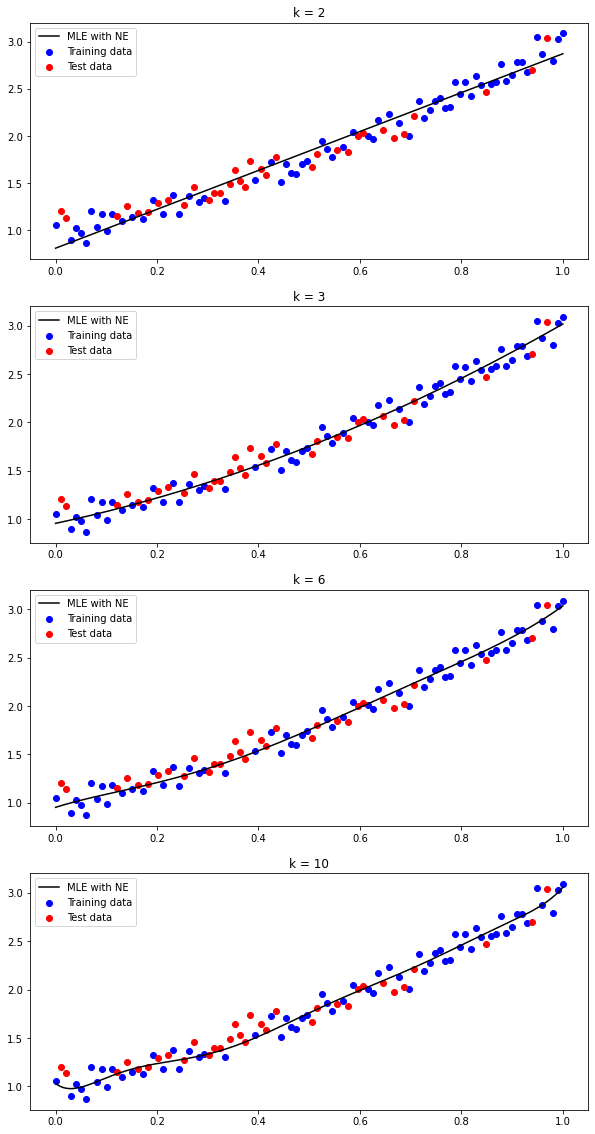

In [115]:
ks_MLE = [2, 3, 6, 10]
thetas_MLE = []
methods = ['NE', 'NE', 'NE', 'NE']
errs_train_MLE = []
errs_test_MLE = []

for i, k in enumerate(ks_MLE):
    thetas_MLE.append(MLE((X_train, Y_train), k, methods[i]))
    errs_train_MLE.append(avg_abs_err(thetas_MLE[-1], (X_train, Y_train)))
    errs_test_MLE.append(avg_abs_err(thetas_MLE[-1], (X_test, Y_test)))

fig, ax = plt.subplots(len(ks_MLE), figsize=(10, 20))

for i in range(len(ks_MLE)):
    X_plot = np.linspace(a, b, 1000)
    Y_plot = phi(X_plot, ks_MLE[i]) @ thetas_MLE[i]
    ax[i].plot(X_plot, Y_plot, label=f'MLE with {methods[i]}', color='k')
    ax[i].scatter(X_train, Y_train, label='Training data', color='b')
    ax[i].scatter(X_test, Y_test, label='Test data', color='r')
    ax[i].set_title('k = ' + str(ks_MLE[i]))
    ax[i].legend()

In [116]:
def theta_error(theta):
    ktry = len(theta)
    theta_true = np.ones((ktry,))
    return np.linalg.norm(theta - theta_true, 2, axis=0)

thetaerror = [theta_error(theta) for theta in thetas_MLE]
print(thetaerror)

[1.0773723539116653, 0.14754669008373889, 27.88944692144149, 10273.26330933406]


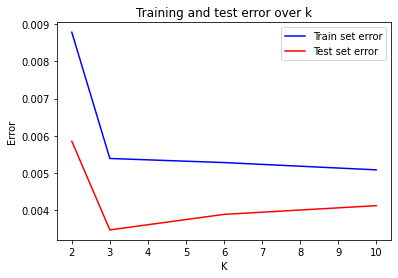

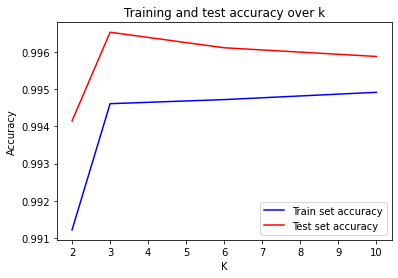

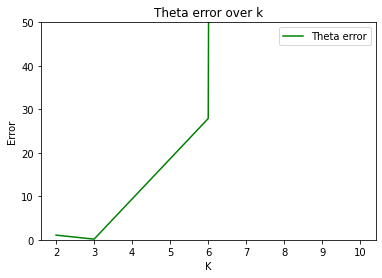

In [117]:
plt.plot(ks_MLE, errs_train_MLE, label = "Train set error", color='b')
plt.plot(ks_MLE, errs_test_MLE, label = "Test set error", color='r')
plt.legend()
plt.title("Training and test error over k")
plt.xlabel("K")
plt.ylabel("Error")
plt.show()

def theta_error(theta):
    ktry = len(theta)
    theta_true = np.ones((ktry,))
    return np.linalg.norm(theta - theta_true, 2, axis=0)

thetaerror = [theta_error(theta) for theta in thetas_MLE]

acctrain = [1-e for e in errs_train_MLE]
acctest = [1-e for e in errs_test_MLE]
plt.plot(ks_MLE, acctrain, label = "Train set accuracy", color='b')
plt.plot(ks_MLE, acctest, label = "Test set accuracy", color='r')
plt.legend()
plt.title("Training and test accuracy over k")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()

plt.plot(ks_MLE, thetaerror, label = "Theta error", color='g')
plt.legend()
plt.title("Theta error over k")
plt.xlabel("K")
plt.ylabel("Error")
plt.ylim(0, 50)
plt.show()



In [118]:
def grad_f_MAP(lam):
    return lambda X, Y, theta: phi(X, len(theta)).T @ ((phi(X, len(theta)) @ theta) - Y) + 2 * lam * theta

def theta_calc_eq_MAP(phi_X, Y, lam, K):
    first_fact = phi_X.T @ phi_X + (lam * np.eye(K))
    second_fact = phi_X.T @ Y
    try:
        L = scipy.linalg.cholesky(first_fact, lower = True)
        y = scipy.linalg.solve_triangular(L, b, lower = True)
        theta_found_normeq = scipy.linalg.solve_triangular(L.T, y)
    except:
        theta_found_normeq = np.linalg.solve(first_fact, second_fact)
    return theta_found_normeq

def MAP(D, K, lam, method):
    X, Y = D
    theta = None
    if method == "NE":
        theta = theta_calc_eq_MAP(phi(X, K), Y, lam, K)
    if method == "GD":
        theta = GD(np.ones((K,)), D, grad_f_MAP(lam))
    if method == "SGD":
        w0 = np.random.normal(mean, var, K)
        theta = SGD(w0, D, grad_f_MAP(lam))
    return theta

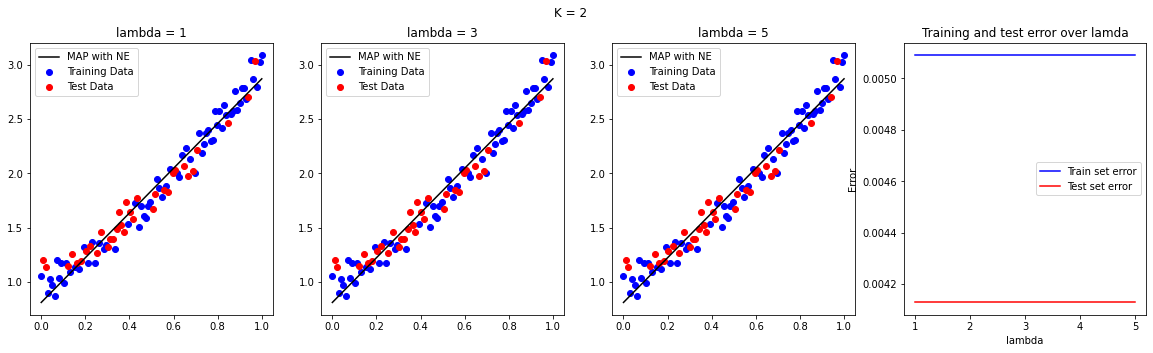

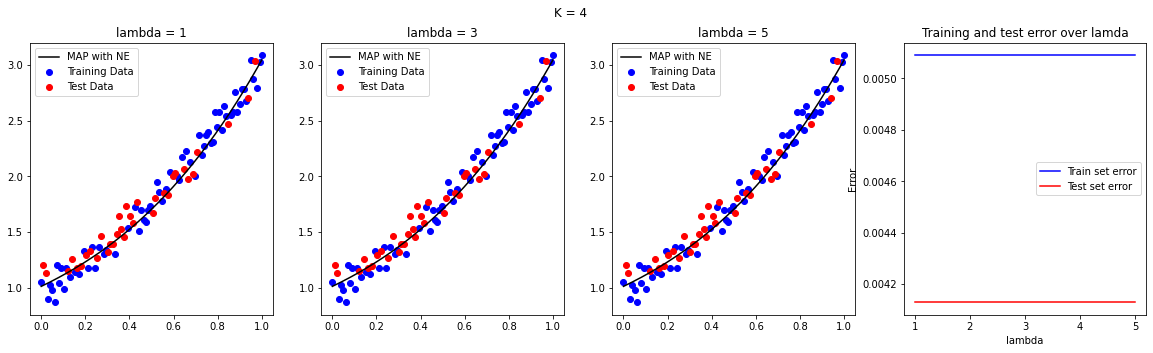

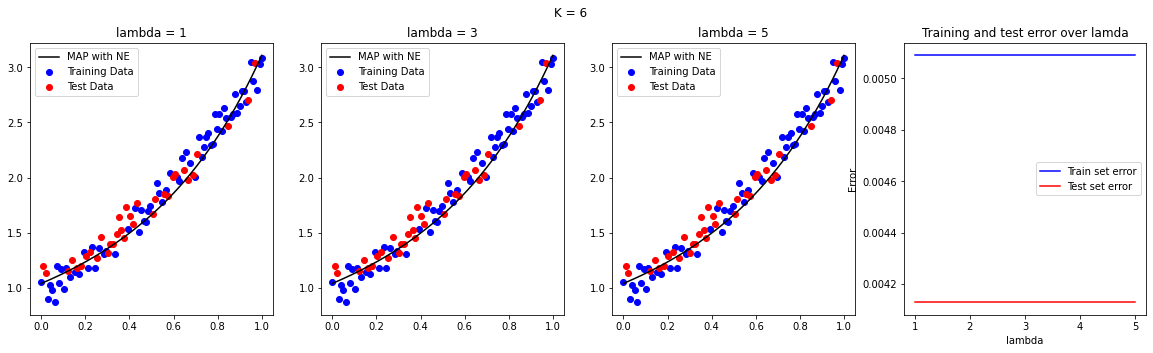

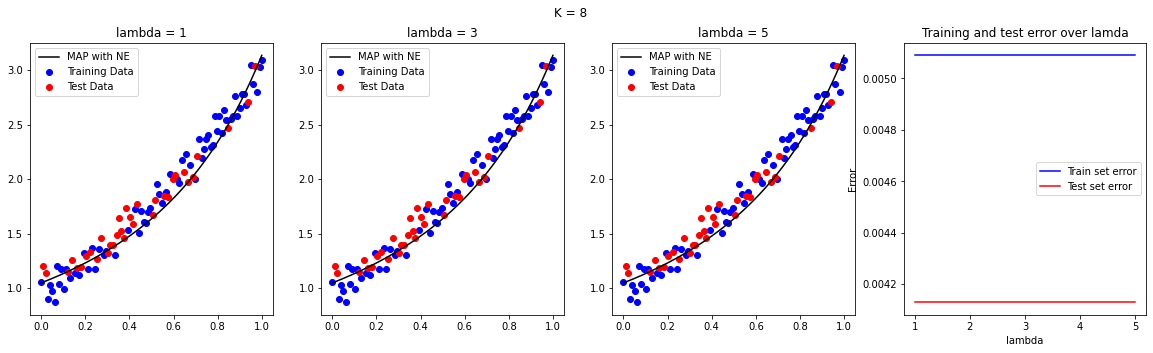

In [119]:
ks_MAP = [2, 4, 6, 8]
thetas_MAP = []
methods = ["NE", "NE", "NE", "NE"]
lams = [1, 3, 5]
errs_train_MAP = []
errs_test_MAP = []

for i, k in enumerate(ks_MAP):
    thetas_MAP_l = []
    errs_train_MAP_l = []
    errs_test_MAP_l = []
    for lam in lams:
        thetas_MAP_l.append(MAP((X_train, Y_train), k, i, methods[i]))
        errs_train_MAP_l.append(avg_abs_err(thetas_MLE[-1], (X_train, Y_train)))
        errs_test_MAP_l.append(avg_abs_err(thetas_MLE[-1], (X_test, Y_test)))
    thetas_MAP.append(thetas_MAP_l)
    errs_train_MAP.append(errs_train_MAP_l)
    errs_test_MAP.append(errs_test_MAP_l)

for i, k in enumerate(ks_MAP):
    plt.figure(figsize = (20, 5))
    plt.suptitle(f"K = {k}")
    for j, lam in enumerate(lams):
        theta_MAP = thetas_MAP[i][j]
        X_plot = np.linspace(a, b, 1000)
        Y_plot = phi(X_plot, k) @ theta_MAP
        plt.subplot(1, 4, j+1)
        plt.plot(X_plot, Y_plot, label=f"MAP with {methods[i]}", color="k")
        plt.scatter(X_train, Y_train, label= "Training Data", color='b')
        plt.scatter(X_test, Y_test, label="Test Data", color='r')
        plt.title(f"lambda = {lam}")
        plt.legend()
    plt.subplot(1, 4, 4)
    plt.plot(lams, errs_train_MAP[i], color='b', label="Train set error")
    plt.plot(lams, errs_test_MAP[i], color='r', label="Test set error")
    plt.legend()
    plt.title("Training and test error over lamda")
    plt.xlabel("lambda")
    plt.ylabel("Error")
    plt.show()

MLE test error:  0.003997191900111841
MAP test error:  [0.0035846866373777366, 0.005218527035910885, 0.007507508504838219]


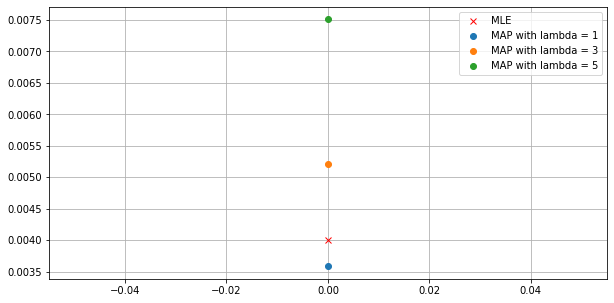

In [120]:
K_big = 26

theta_MLE_big = MLE((X_train, Y_train), K_big, "NE")
thetas_MAP_big = [MAP((X_train, Y_train), K_big, lam, "NE") for lam in lams]

MLE_err = avg_abs_err(theta_MLE_big, (X_test, Y_test))
MAP_err = [avg_abs_err(theta, (X_test, Y_test)) for theta in thetas_MAP_big]

plt.figure(figsize = (10, 5))
plt.plot(MLE_err, 'xr', label="MLE")
for i, lam in enumerate(lams):
    plt.plot(MAP_err[i], 'o', label=f"MAP with lambda = {lam}")
plt.legend()
plt.grid()

print("MLE test error: ", MLE_err)
print("MAP test error: ", MAP_err)

In [121]:
def err(theta, k):
    theta_true = np.concatenate((np.ones((k, )), np.zeros((len(theta) - k,))))
    return ((np.linalg.norm(theta - theta_true)) / (np.linalg.norm(theta_true)))

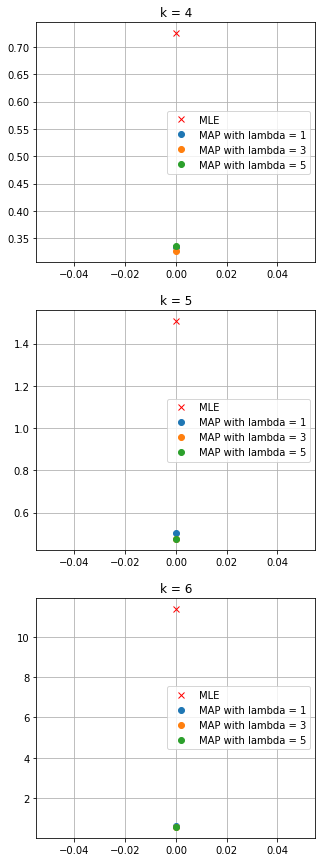

In [122]:
ks = [4, 5, 6]
lams = [1, 3, 5]

plt.figure(figsize=(5, 15))
for i, k in enumerate(ks):
    theta_MLE = MLE((X_train, Y_train), k, "NE")
    thetas_MAP = [MAP((X_train, Y_train), k, lam, "NE") for lam in lams]
    MLE_err = err(theta_MLE, k)
    MAP_err = [err(theta_MAP, k) for theta_MAP in thetas_MAP]
    
    plt.subplot(len(ks), 1, i+1)
    plt.plot(MLE_err, 'xr', label="MLE")
    
    for j, lam in enumerate(lams):
        plt.plot(MAP_err[j], 'o', label=f"MAP with lambda = {lam}")
    plt.legend()
    plt.grid()
    plt.title(f'k = {k}')

In [123]:
testMLE = MLE((X_train, Y_train), K, "GD")
print(f"Theta MLE GD: {testMLE}")
testMLE = MLE((X_train, Y_train), K, "SGD")
print(f"Theta MLE SGD: {testMLE}")
testMLE = MLE((X_train, Y_train), K, "NE")
print(f"Theta MLE NE: {testMLE}")

print()

testMAP = MAP((X_train, Y_train), K, 1, "GD")
print(f"Theta MAP GD: {testMAP}")
testMAP = MAP((X_train, Y_train), K, 1, "SGD")
print(f"Theta MAP SGD: {testMAP}")
testMAP = MAP((X_train, Y_train), K, 1, "NE")
print(f"Theta MAP NE: {testMAP}")

Theta MLE GD: [0.99999882 1.00000313 1.00000306]
Theta MLE SGD: [1.11158272 1.22752074 0.82999087]
Theta MLE NE: [0.95574813 1.12500208 0.93529855]

Theta MAP GD: [0.99997882 0.99998313 0.99998306]
Theta MAP SGD: [1.07154075 1.08649142 1.06328526]
Theta MAP NE: [0.98353152 1.05957332 0.91608028]


# Varying train size


-----------------------------------------
N = 100


#### Method: NE ####


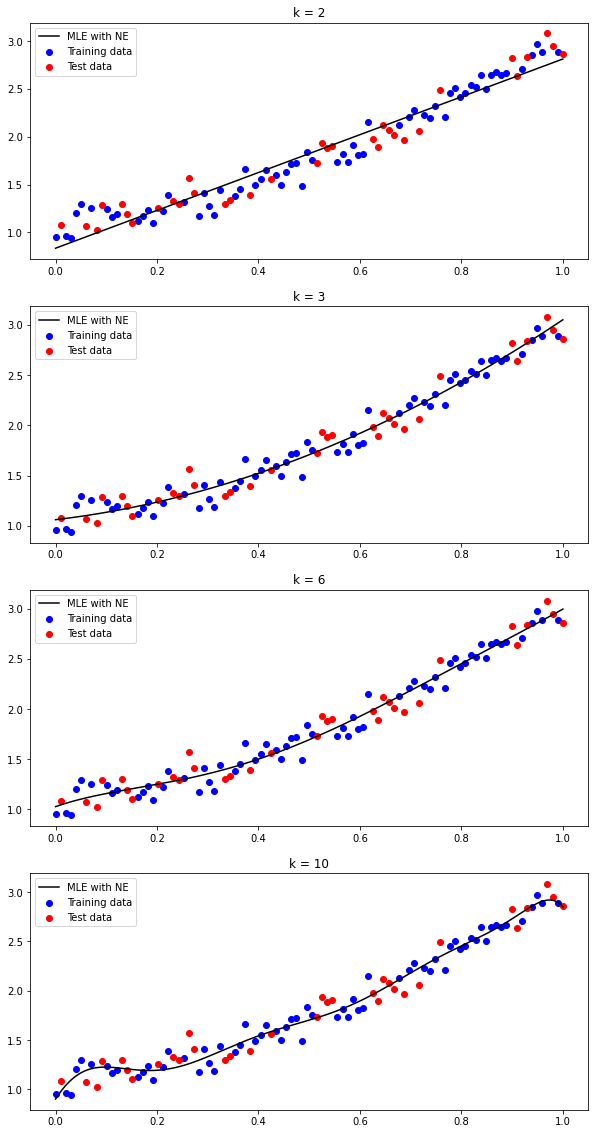

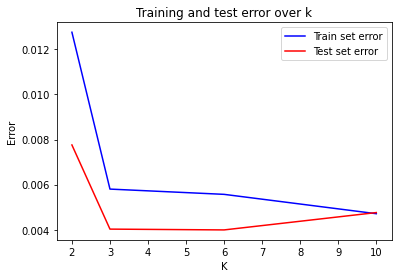

#### Method: GD ####


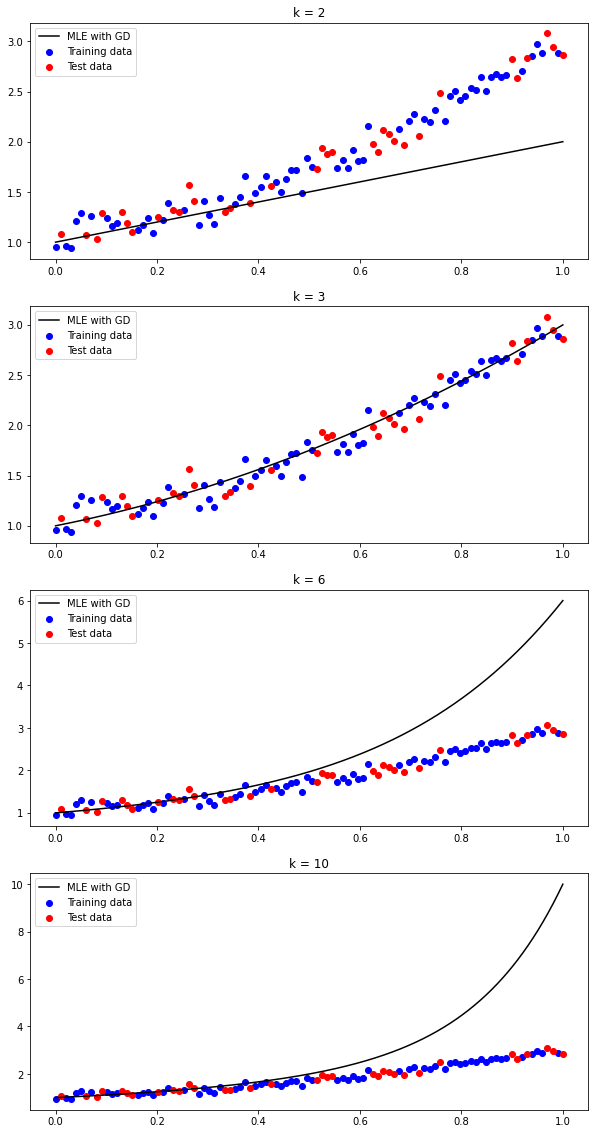

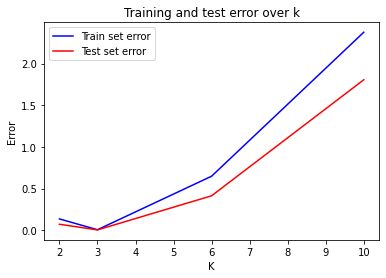

#### Method: SGD ####


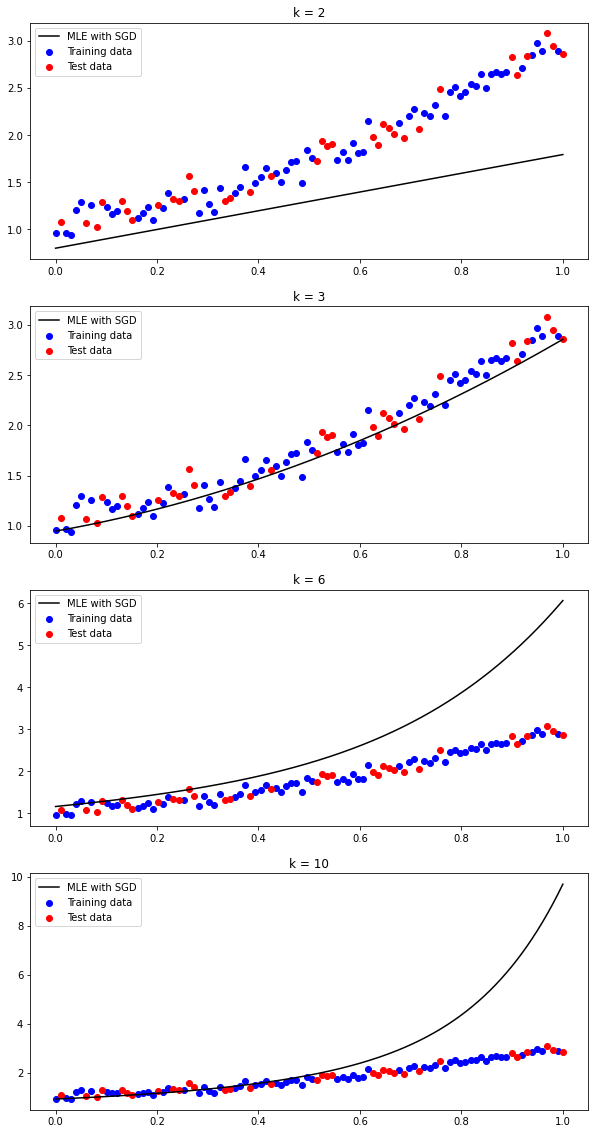

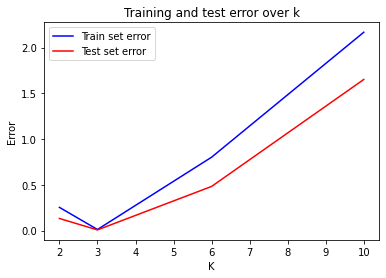

#### Method: NE ####


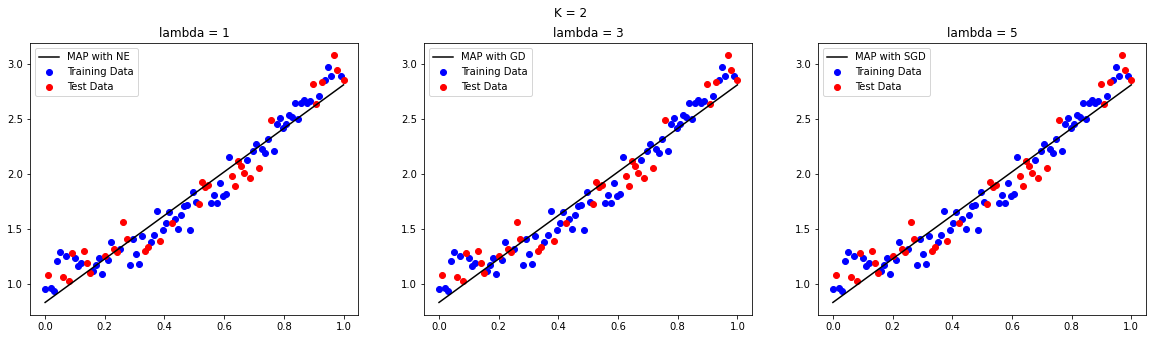

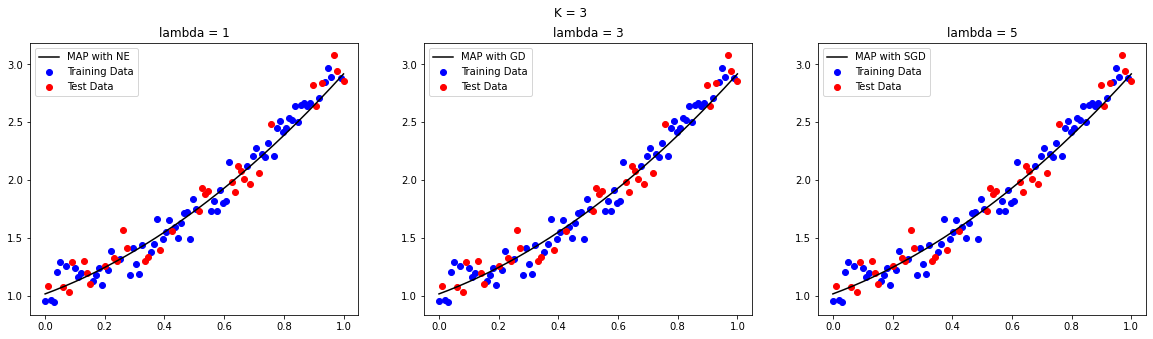

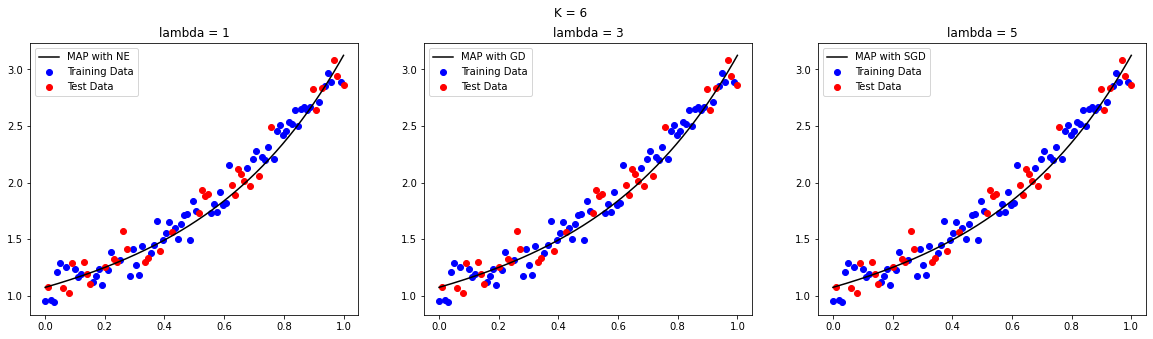

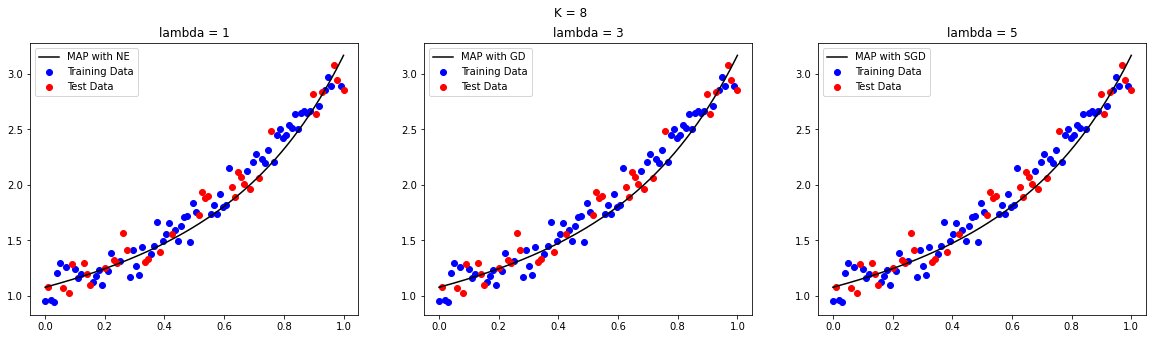

#### Method: GD ####


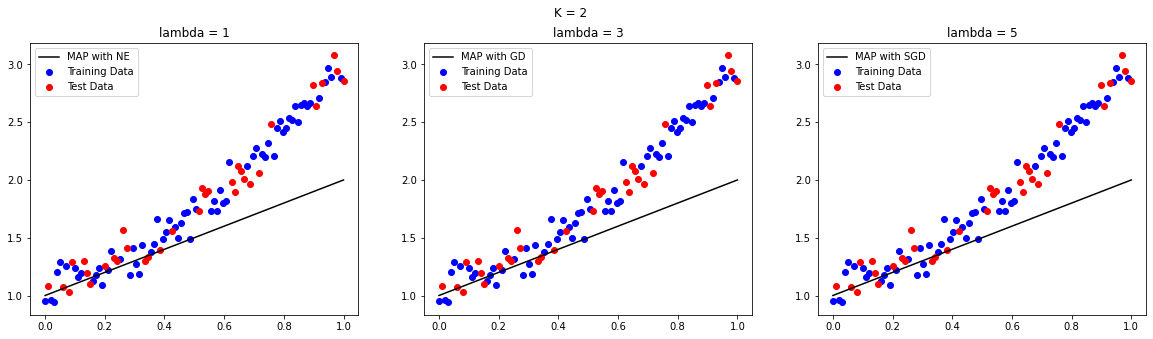

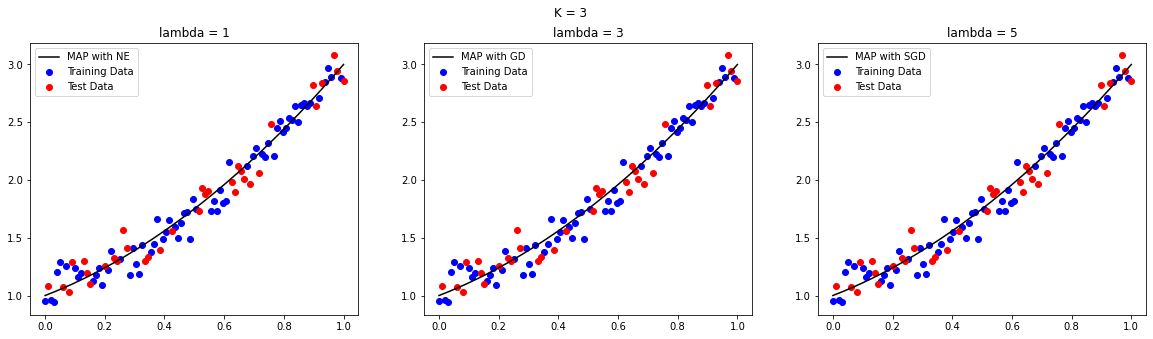

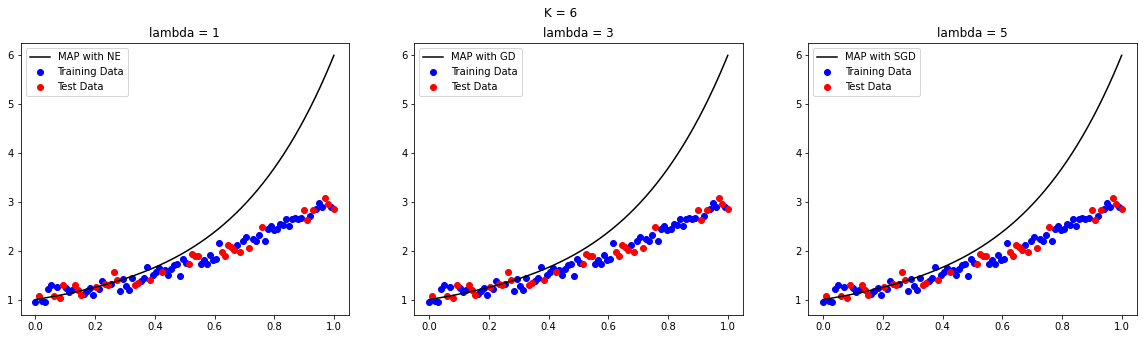

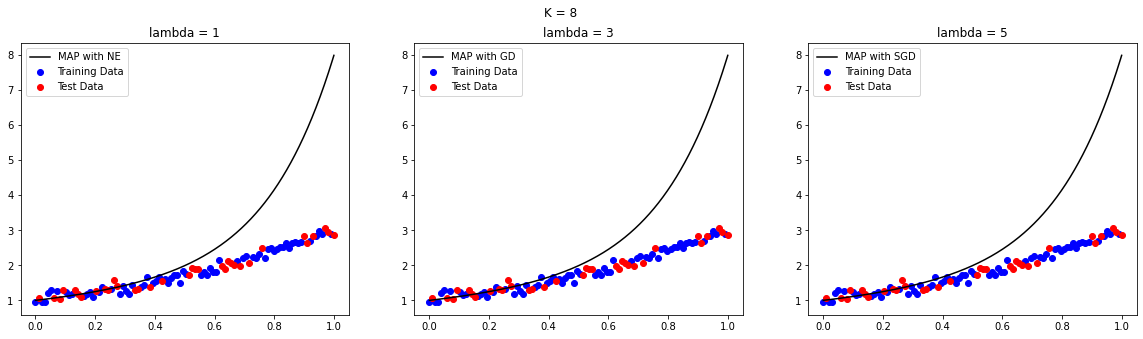

#### Method: SGD ####


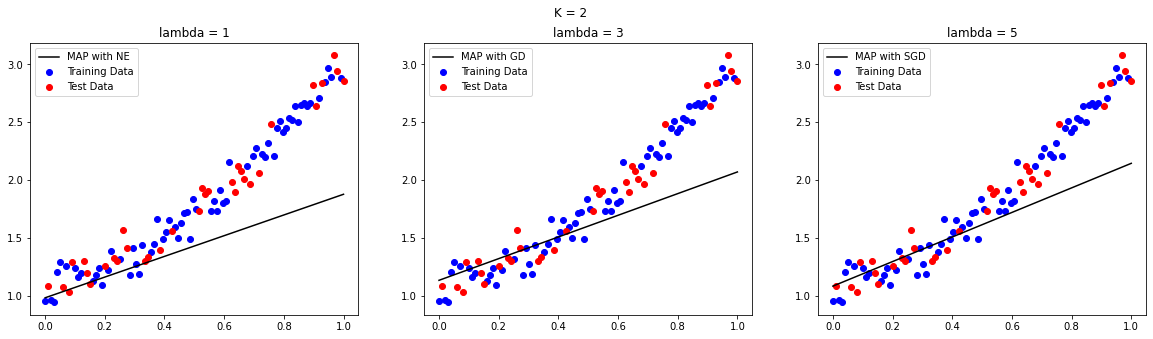

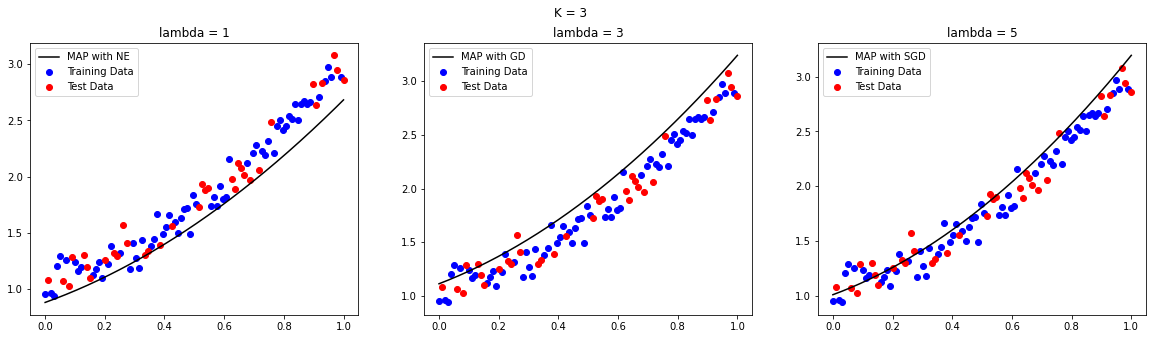

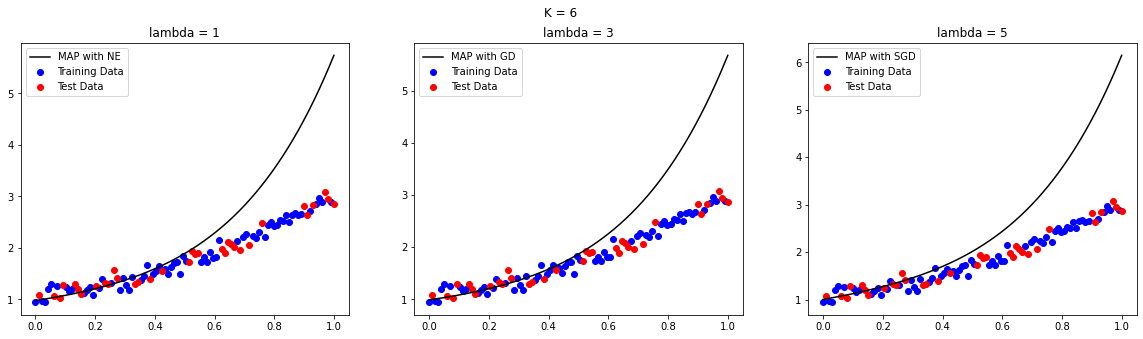

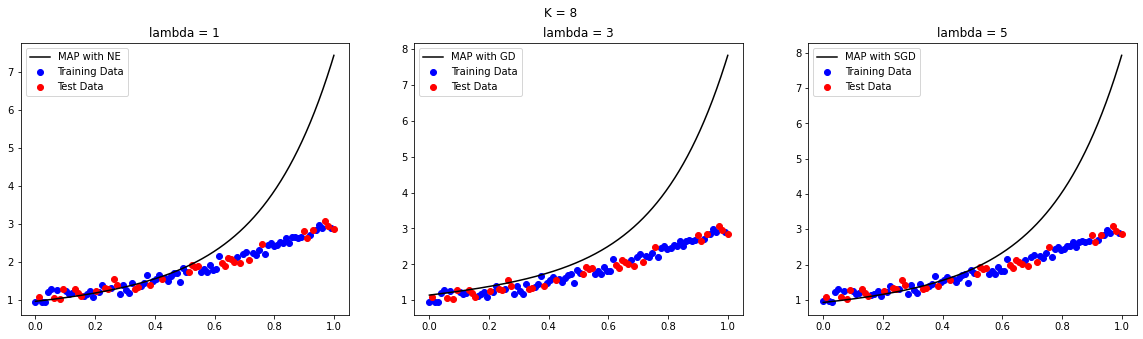

Theta MLE GD: [0.9999934  0.99999591 0.99999843]
Error MLE GD: 4.5745539432504555e-06
Theta MLE SGD: [0.88396429 0.8774367  1.08897381]
Error MLE SGD: 4.5745539432504555e-06
Theta MLE NE: [1.06074321 0.59689549 1.39332401]
Error MLE NE: 0.3270508412549159

Theta MAP GD: [0.9999734  0.99997591 0.99997843]
Error MAP GD: 2.417553585811881e-05
Theta MAP SGD: [1.06866988 1.1242446  0.93184433]
Error MAP SGD: 2.417553585811881e-05
Theta MAP NE: [1.01404261 0.958847   0.94530497]
Error MAP NE: 0.04034150130661324


Method: NE


MLE test error:  0.010682692160247647
MAP test error:  [0.004098001755093, 0.005578646435021423, 0.0077989015504635875]


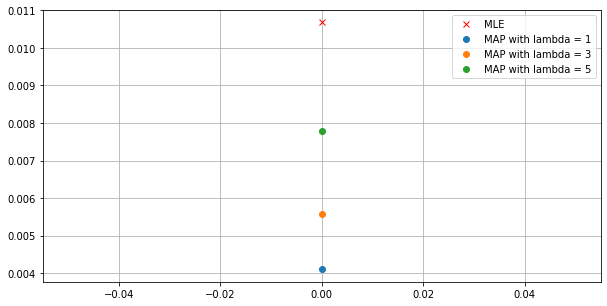

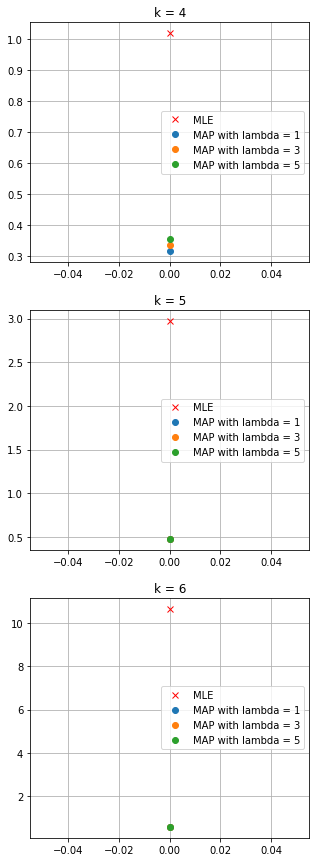

Method: GD


MLE test error:  12.576859876658032
MAP test error:  [12.576257355952801, 12.575052359661605, 12.573847423529385]


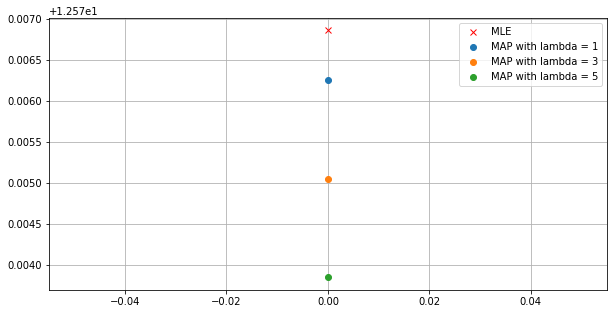

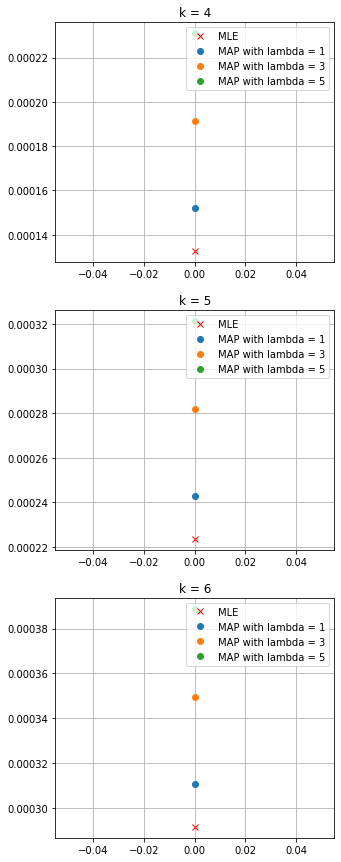

Method: SGD


MLE test error:  12.691712176471778
MAP test error:  [13.027574015135427, 12.206302234145035, 11.8006765351623]


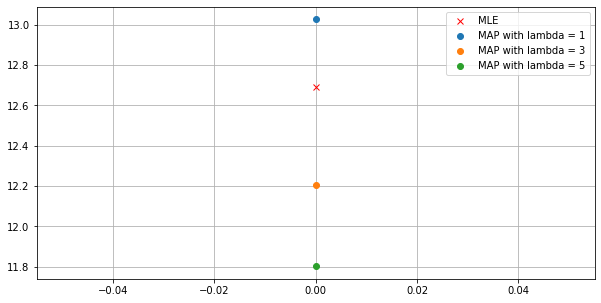

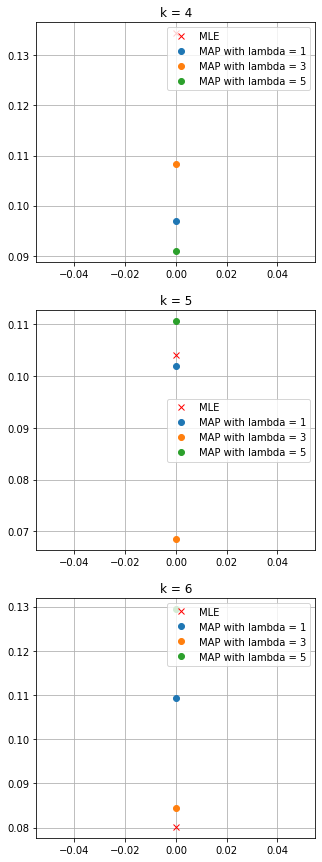



-----------------------------------------
N = 250


#### Method: NE ####


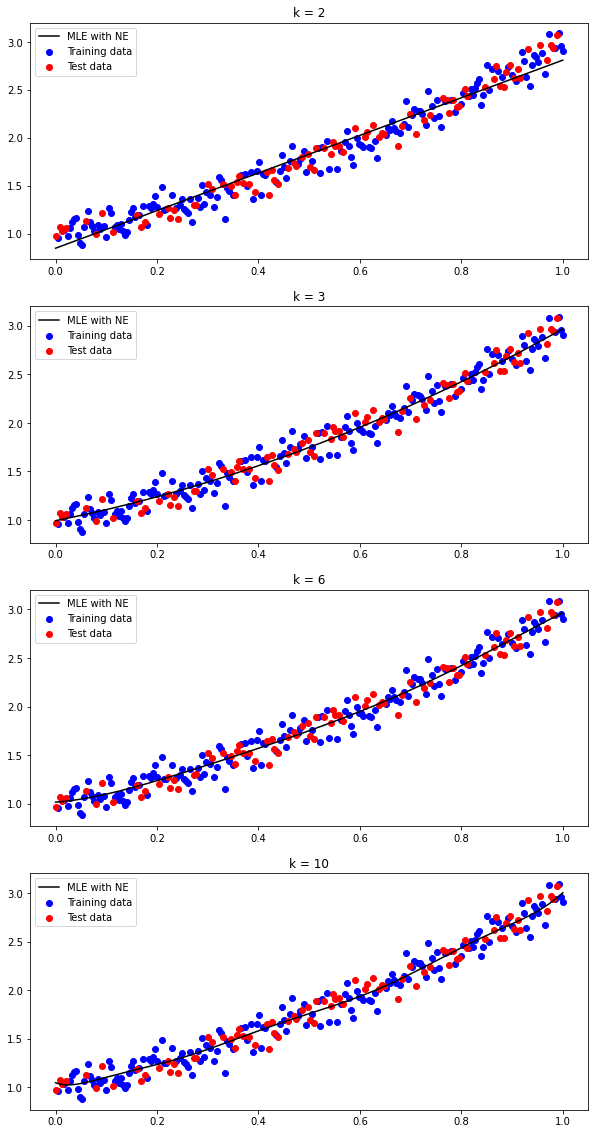

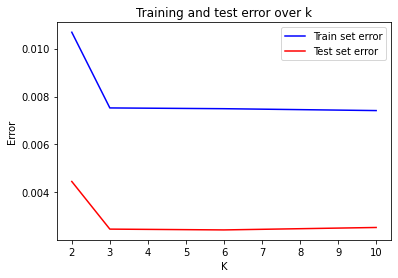

#### Method: GD ####


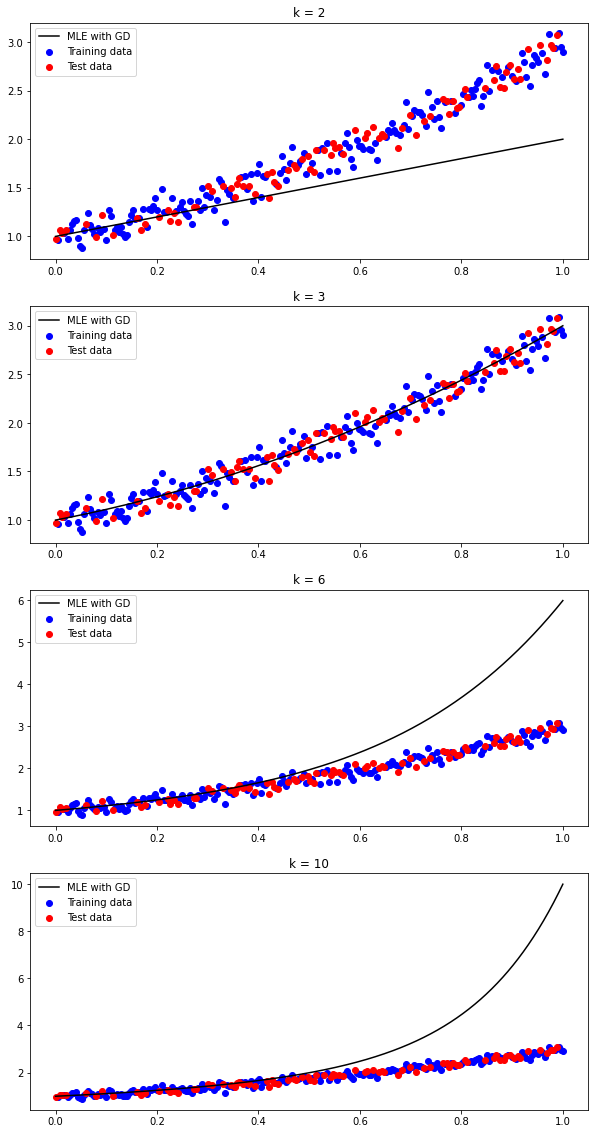

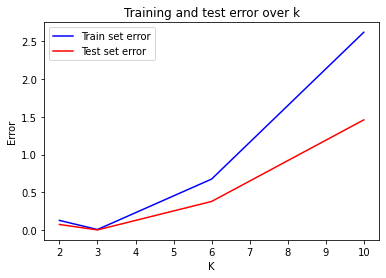

#### Method: SGD ####


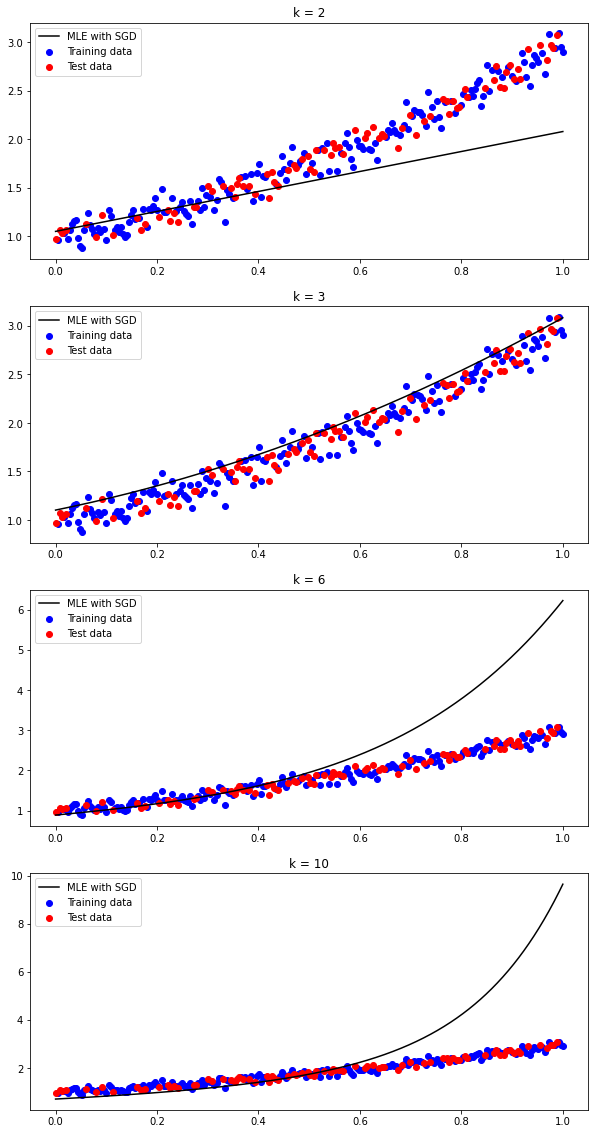

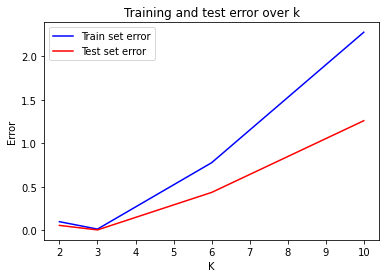

#### Method: NE ####


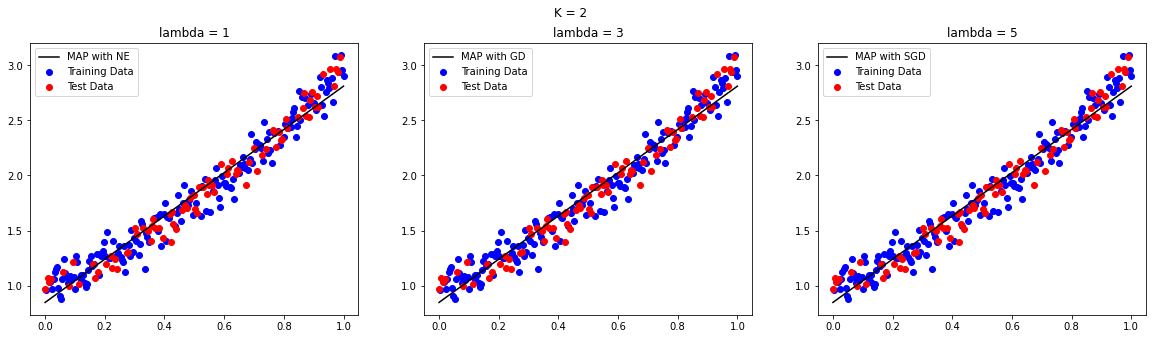

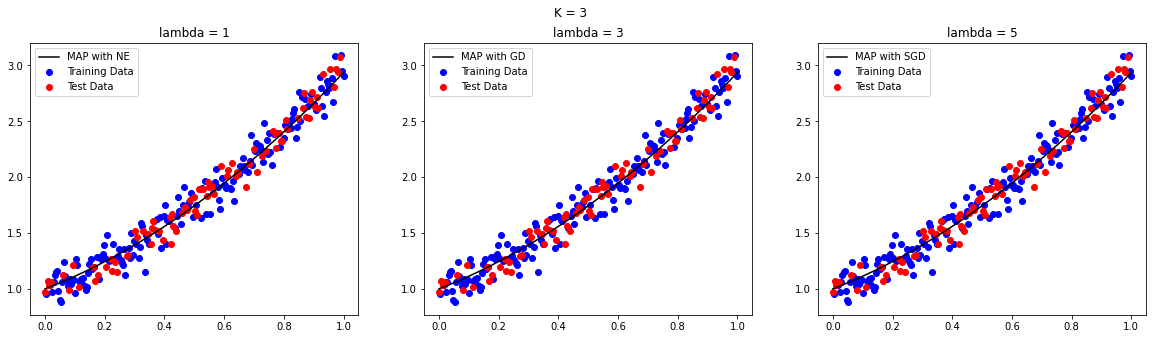

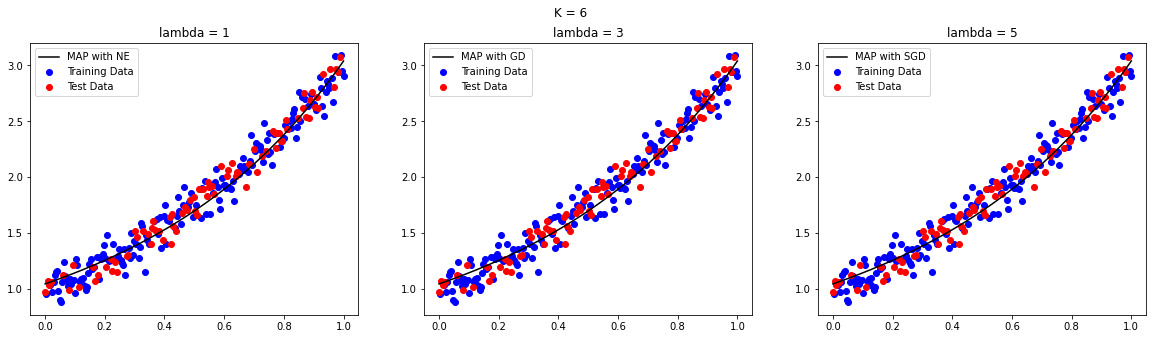

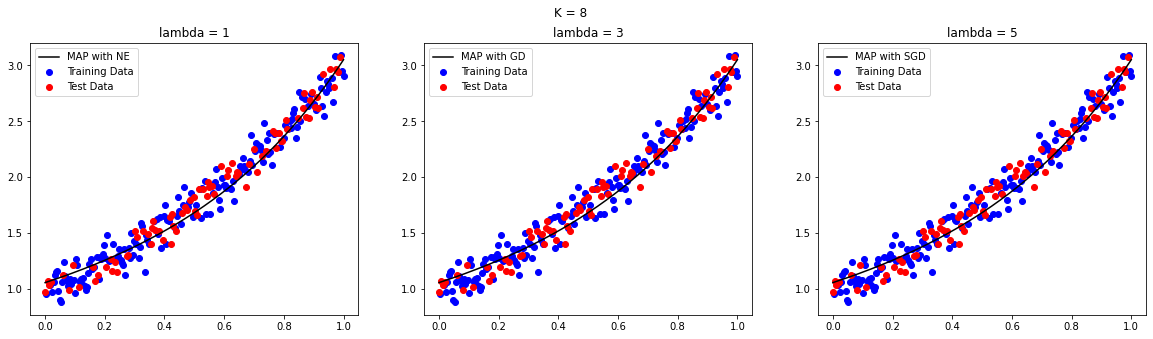

#### Method: GD ####


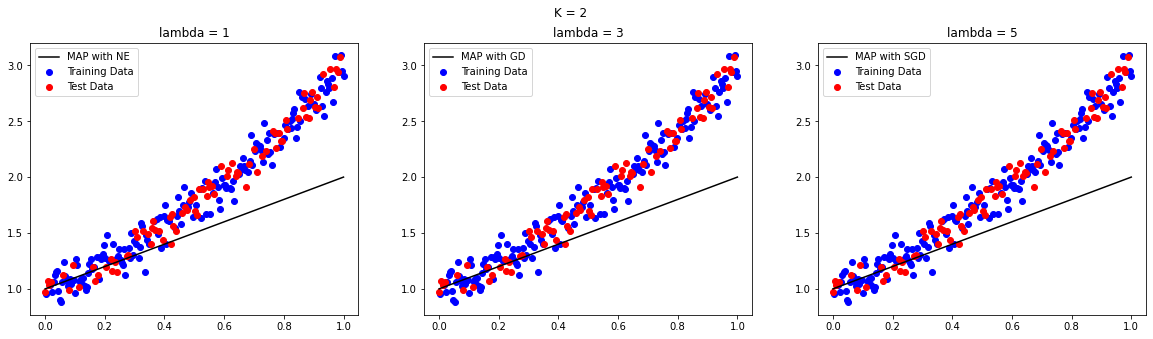

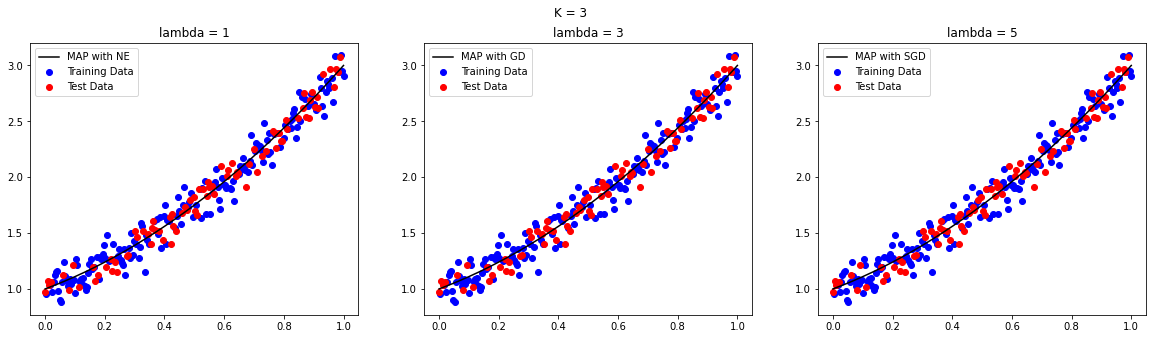

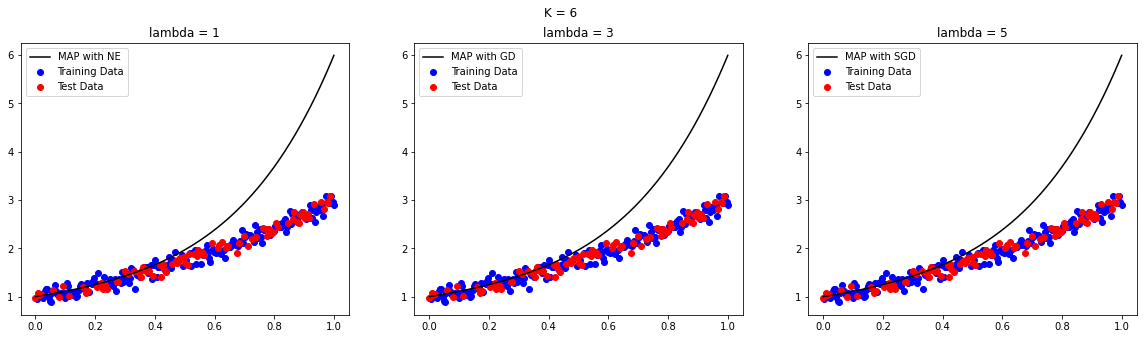

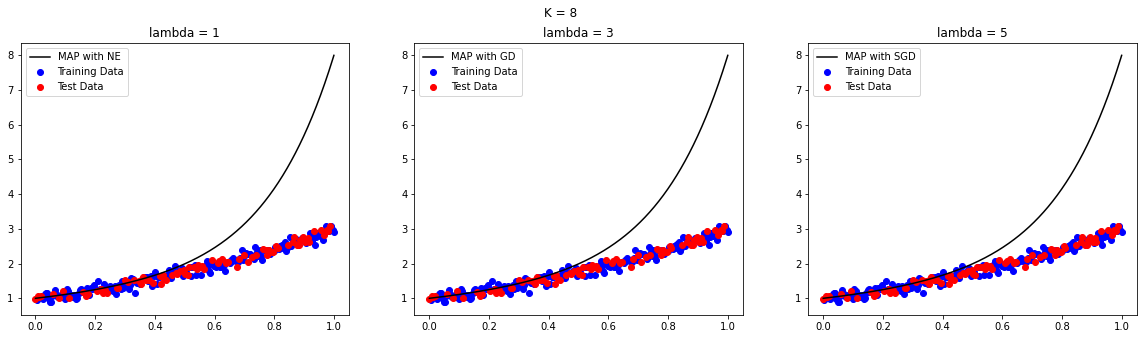

#### Method: SGD ####


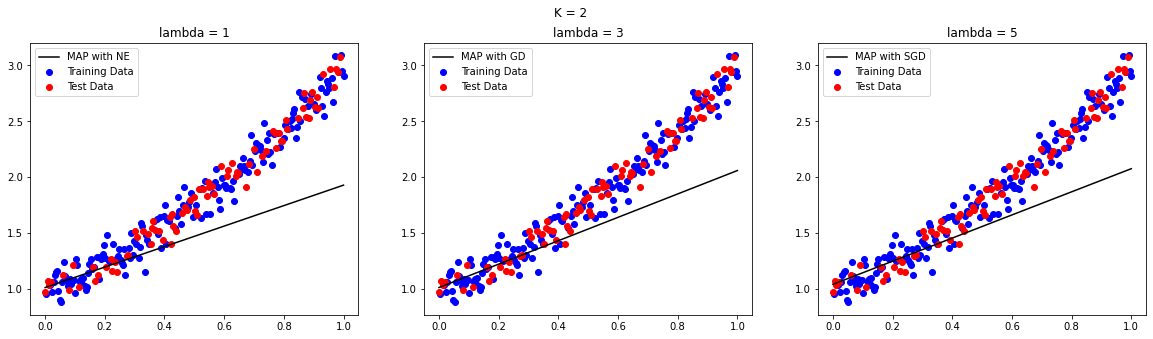

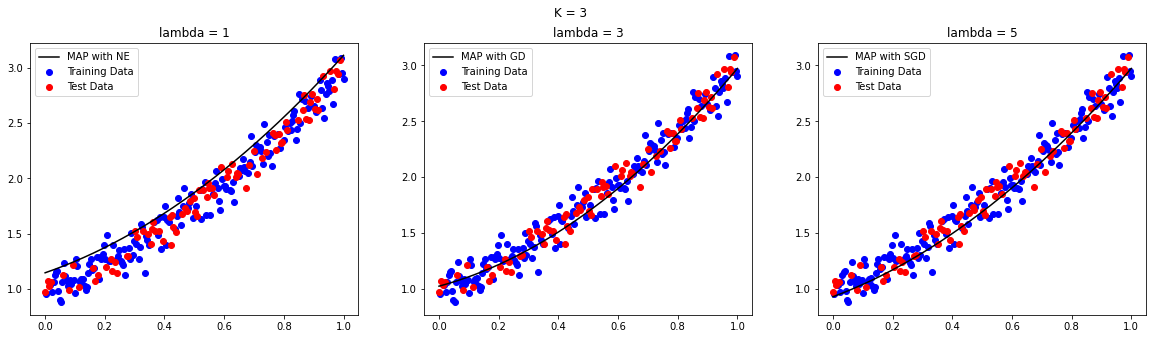

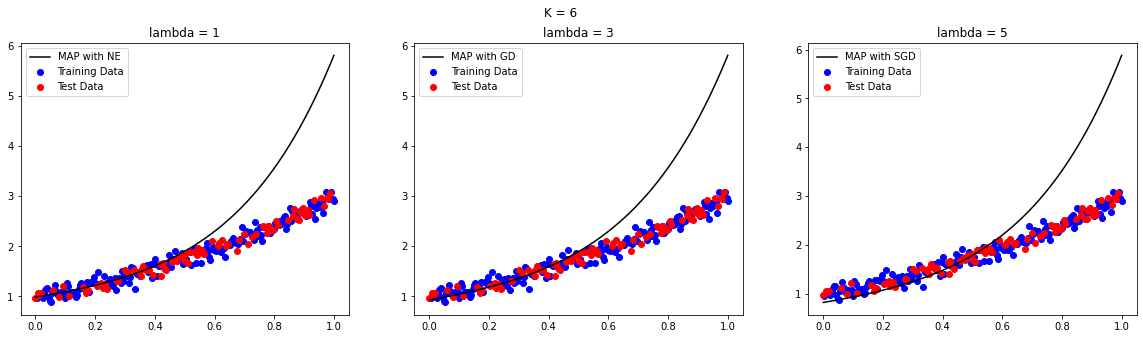

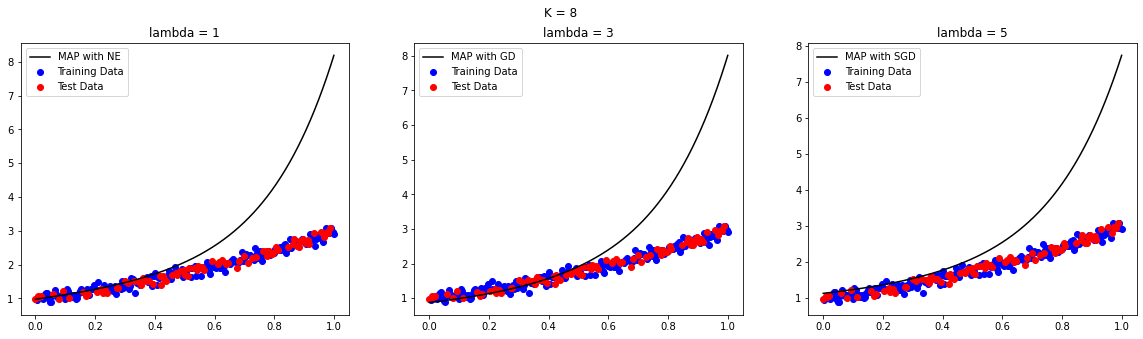

Theta MLE GD: [0.99998759 0.99999037 0.9999918 ]
Error MLE GD: 1.0229016824047064e-05
Theta MLE SGD: [1.05195649 1.13561946 0.92612625]
Error MLE SGD: 1.0229016824047064e-05
Theta MLE NE: [0.99378677 1.04340487 0.93047932]
Error MLE NE: 0.04745423205077429

Theta MAP GD: [0.99996759 0.99997037 0.9999718 ]
Error MAP GD: 3.01294634368655e-05
Theta MAP SGD: [0.95172023 1.0621166  0.94876164]
Error MAP SGD: 3.01294634368655e-05
Theta MAP NE: [1.00117559 1.03724686 0.89773832]
Error MAP NE: 0.06283884788217418


Method: NE


MLE test error:  0.0032423339748865955
MAP test error:  [0.0027760691925442496, 0.0034976006014190344, 0.004294942680152375]


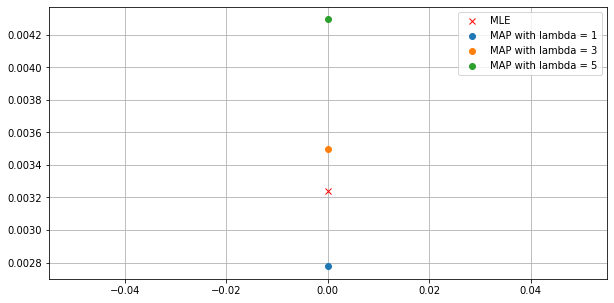

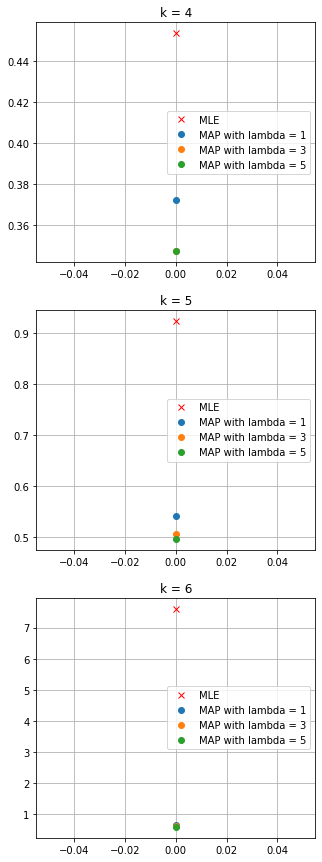

Method: GD


MLE test error:  7.352114519390251
MAP test error:  [7.3517397475029185, 7.350990234247529, 7.350240761684508]


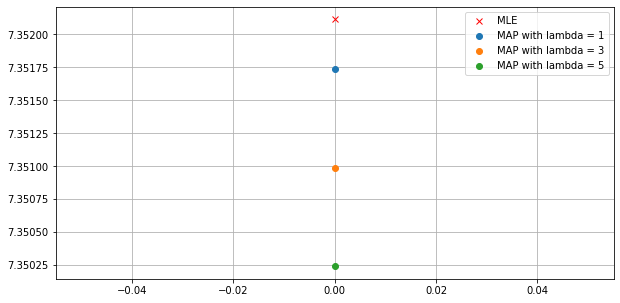

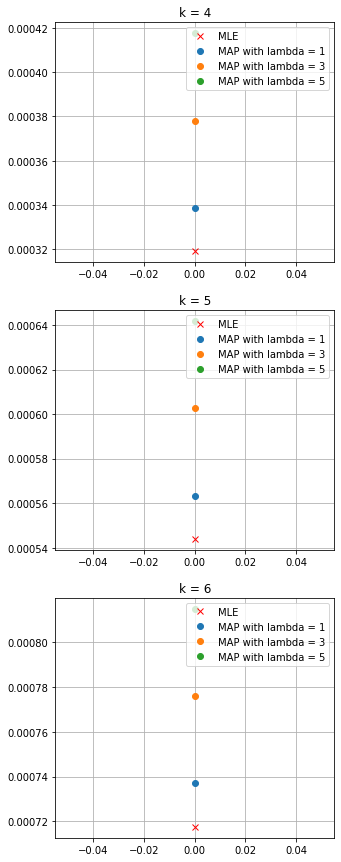

Method: SGD


MLE test error:  6.628948850312542
MAP test error:  [5.8891396259303095, 6.962080180952825, 6.9495382607465235]


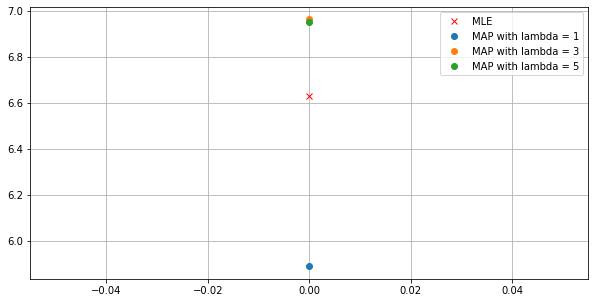

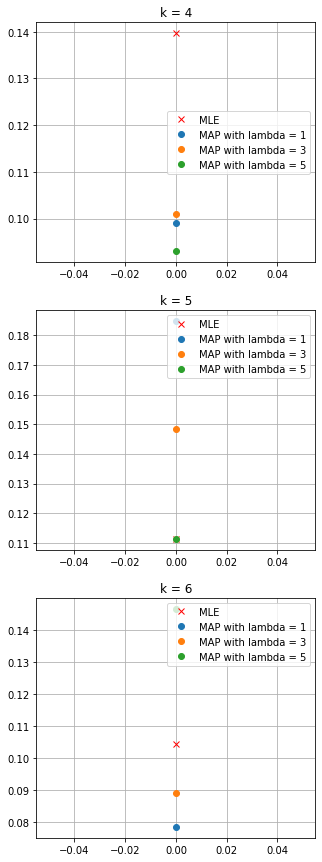



-----------------------------------------
N = 500


#### Method: NE ####


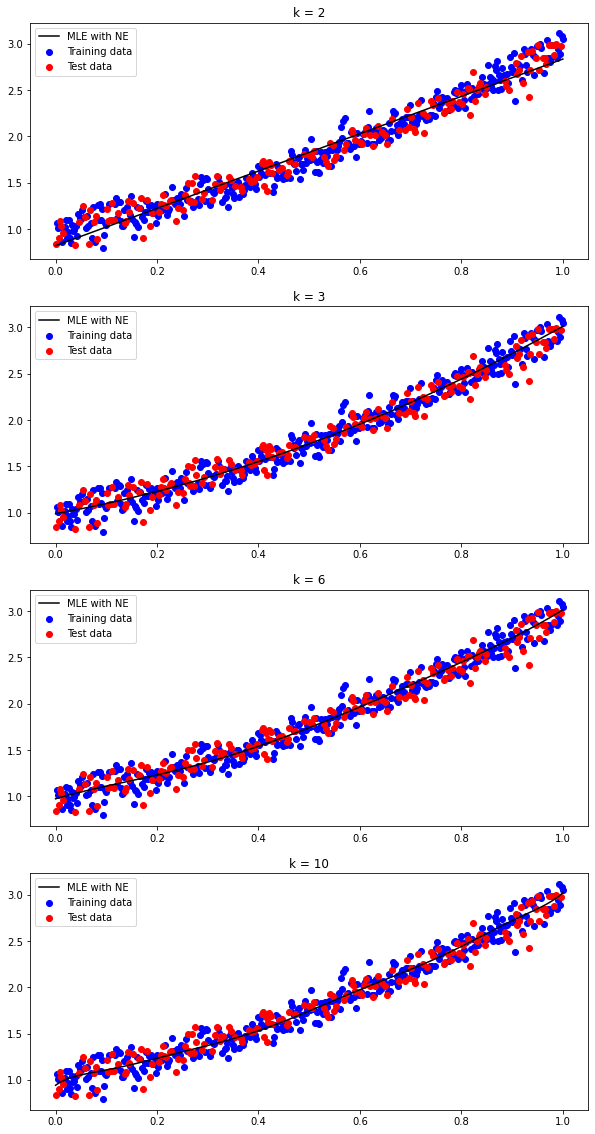

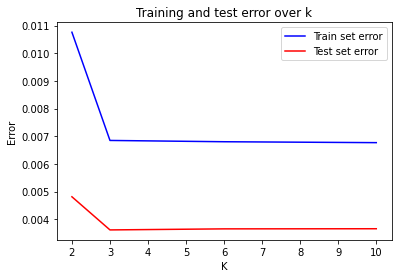

#### Method: GD ####


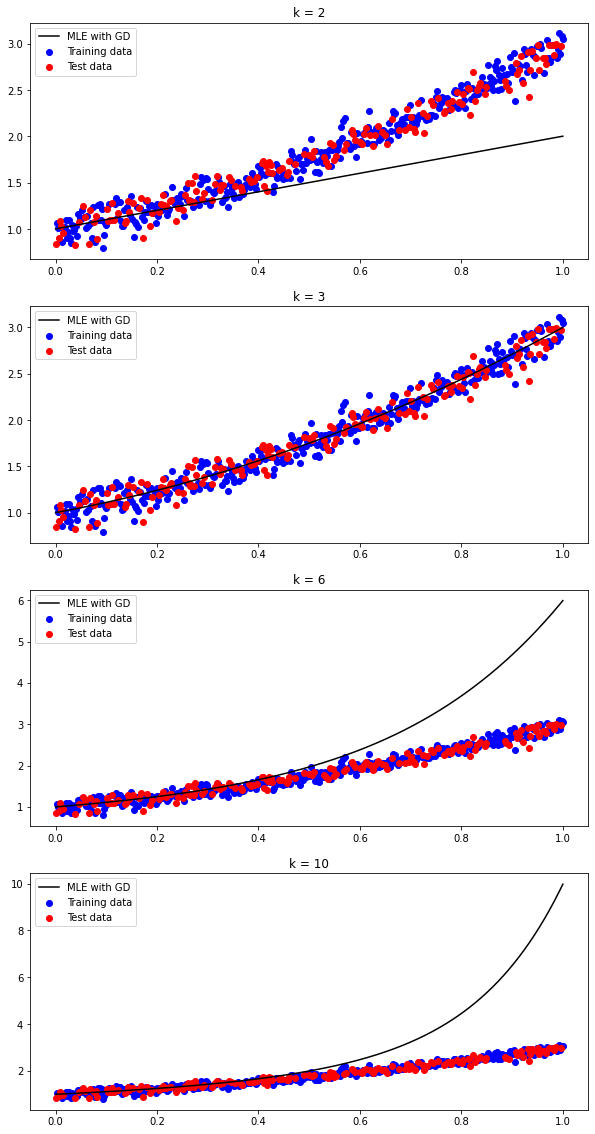

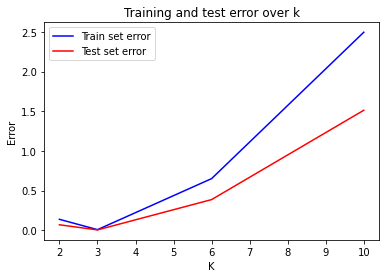

#### Method: SGD ####


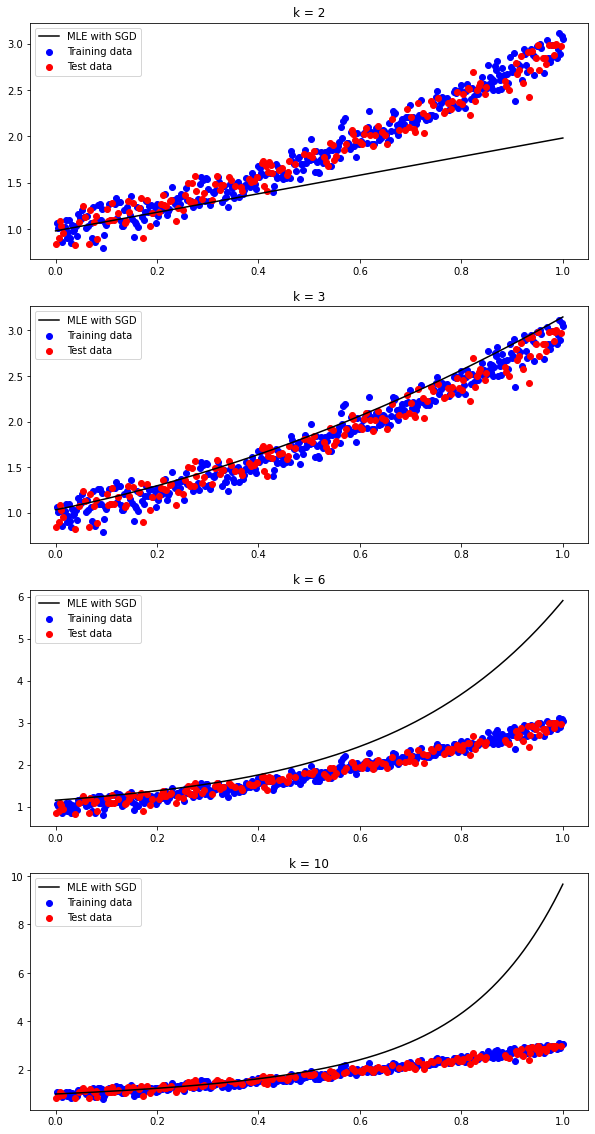

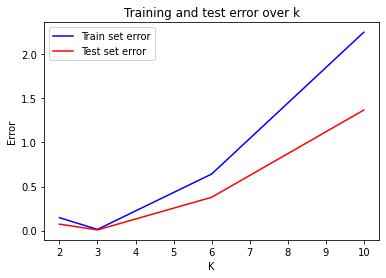

#### Method: NE ####


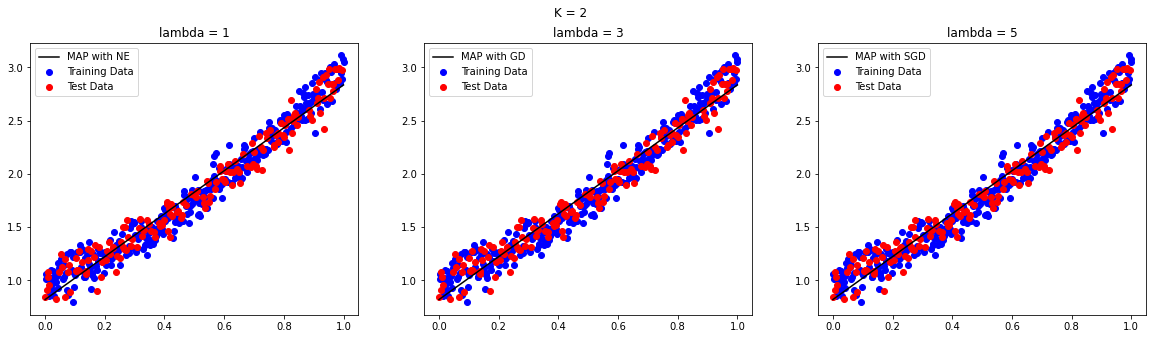

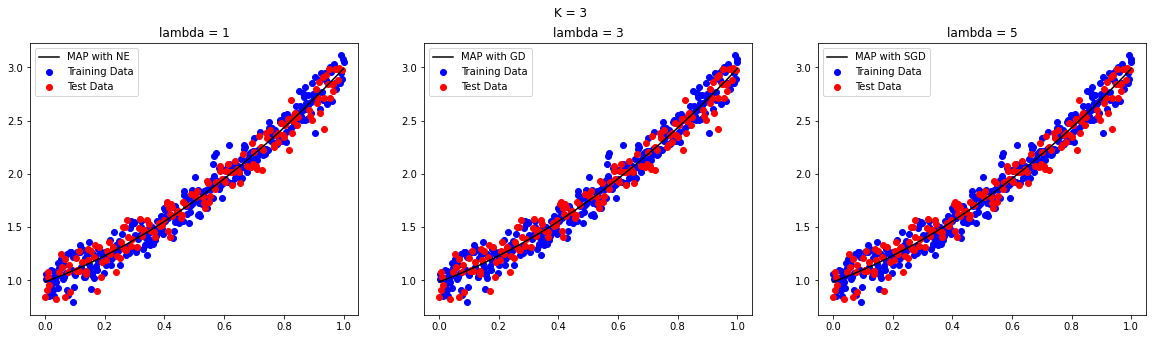

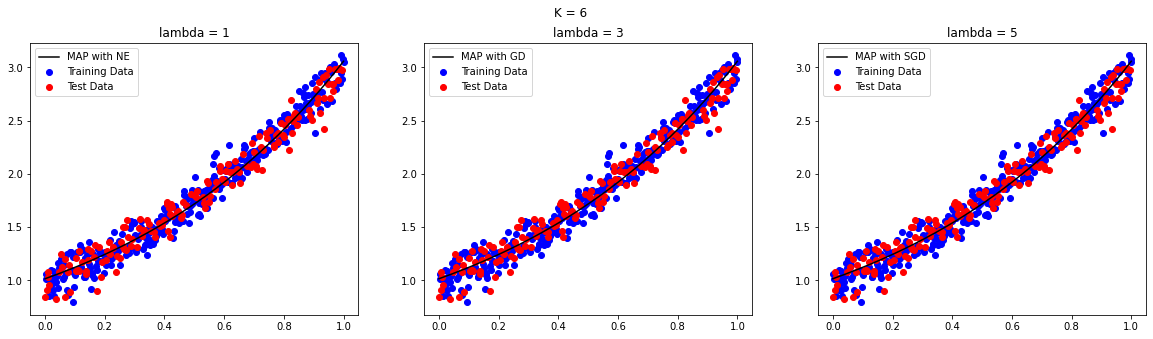

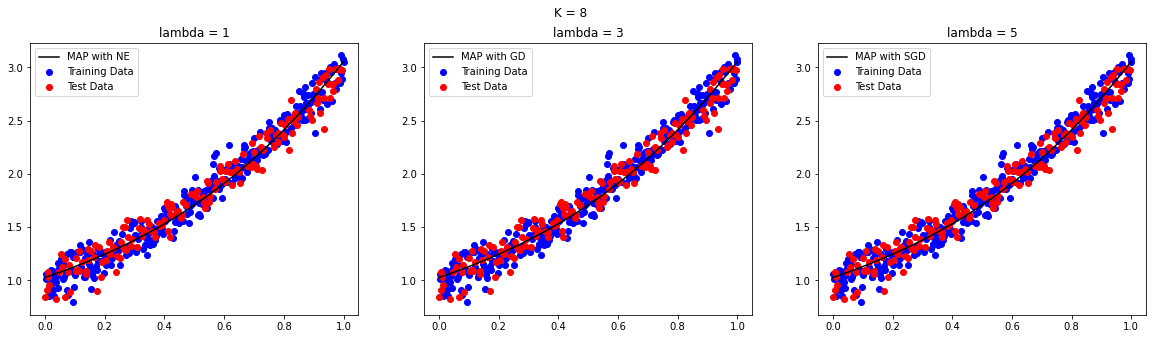

#### Method: GD ####


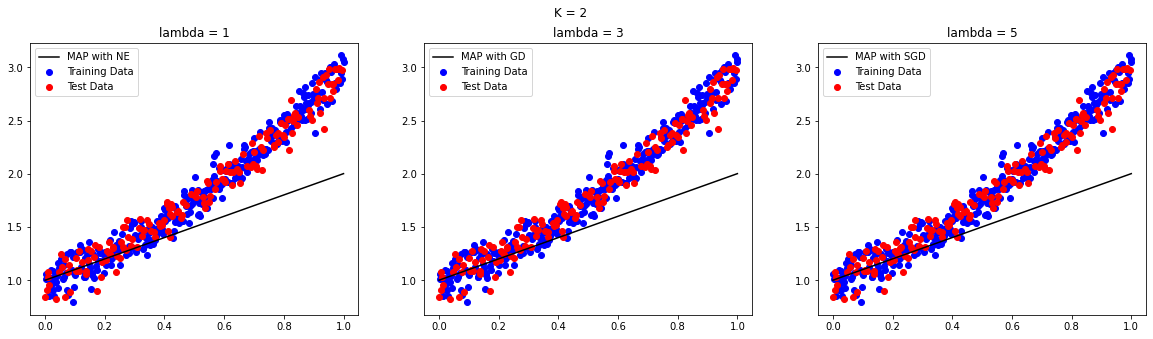

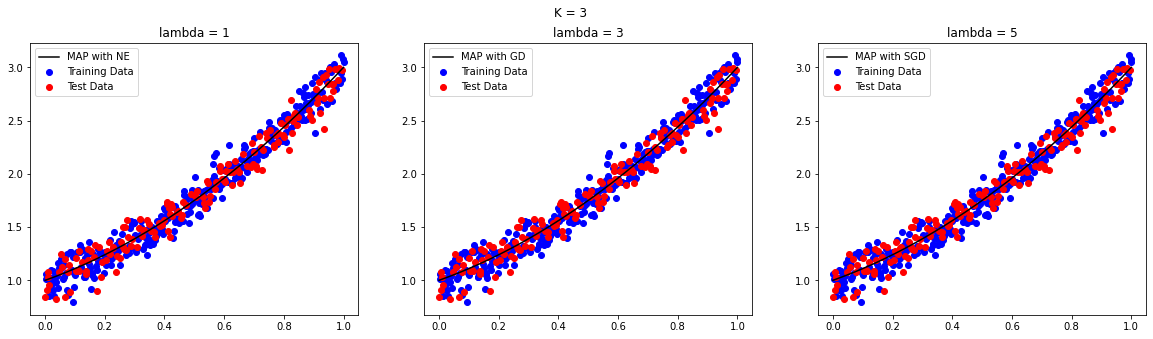

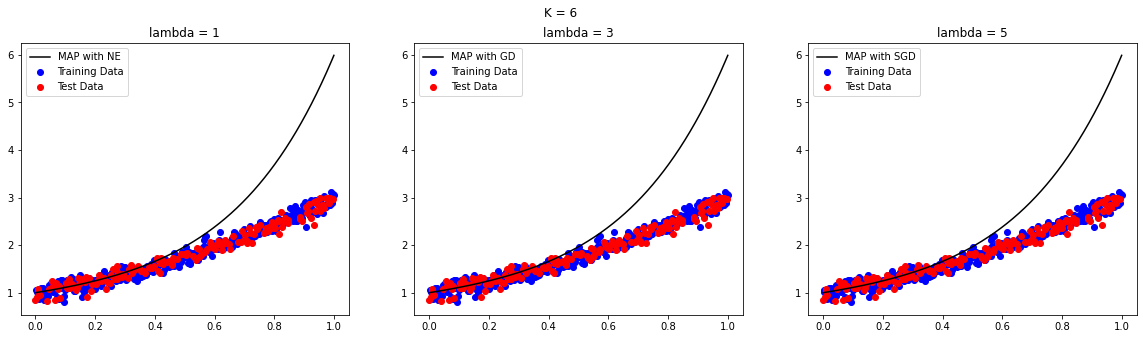

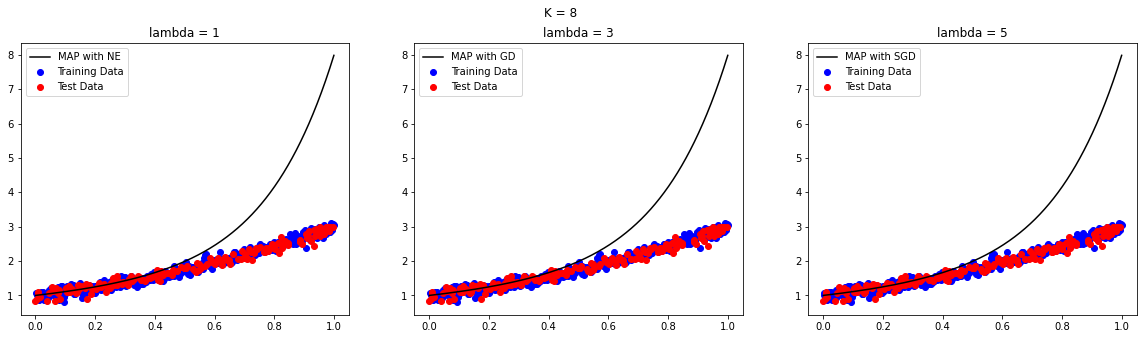

#### Method: SGD ####


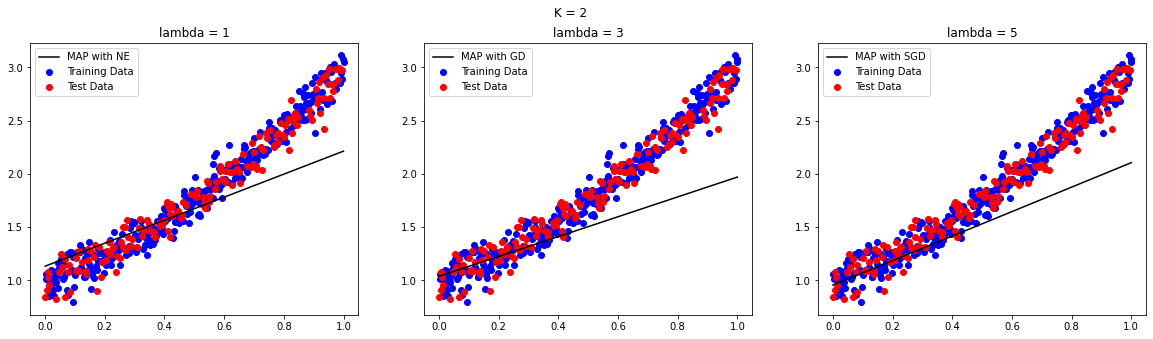

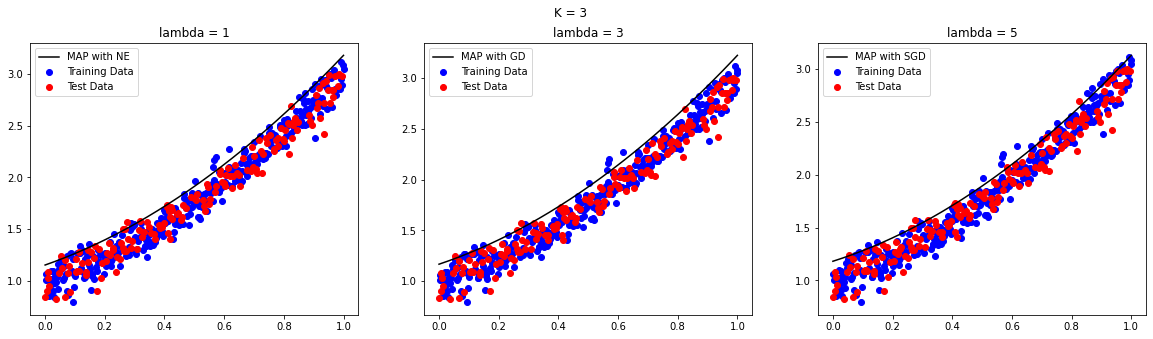

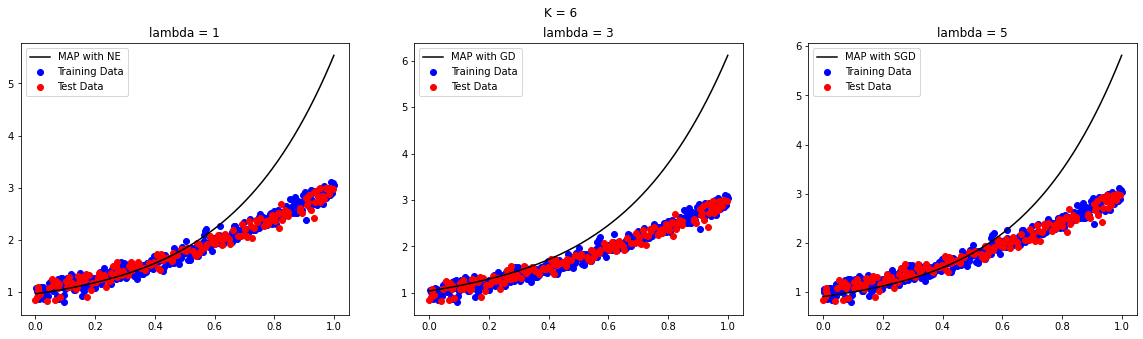

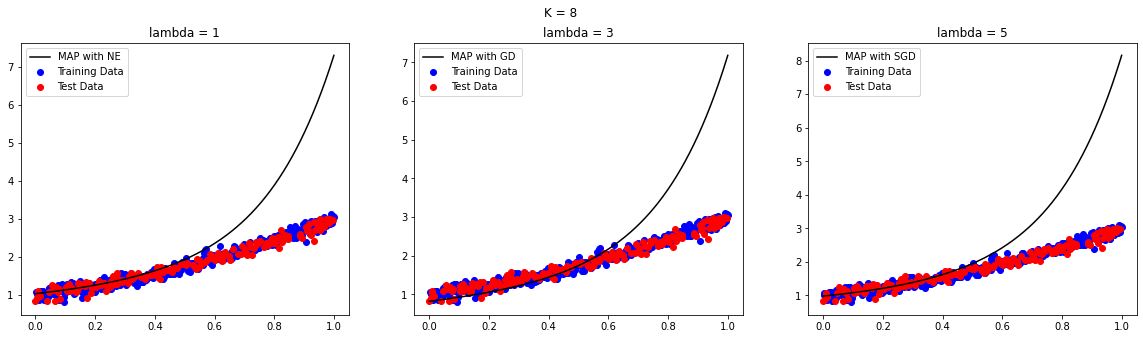

Theta MLE GD: [0.99998314 0.99999814 1.00000145]
Error MLE GD: 9.827134898550464e-06
Theta MLE SGD: [1.09893912 0.89647902 0.9669377 ]
Error MLE SGD: 9.827134898550464e-06
Theta MLE NE: [0.9878378  0.99487373 1.02920201]
Error MLE NE: 0.01850184600657525

Theta MAP GD: [0.99996314 0.99997814 0.99998145]
Error MAP GD: 2.6959565433164283e-05
Theta MAP SGD: [0.85594016 0.76129584 1.03653889]
Error MAP SGD: 2.6959565433164283e-05
Theta MAP NE: [0.98519701 1.032882   0.97095747]
Error MAP NE: 0.026732143912523144


Method: NE


MLE test error:  0.0037421884652182984
MAP test error:  [0.0037085561635559843, 0.0039640668809829424, 0.004236590331237991]


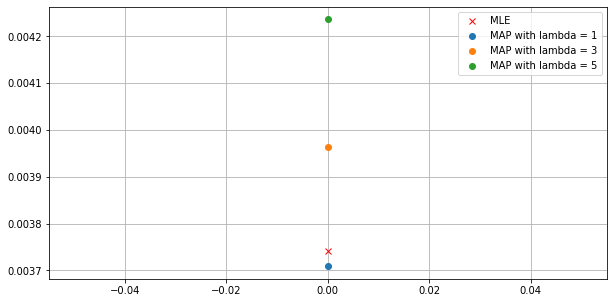

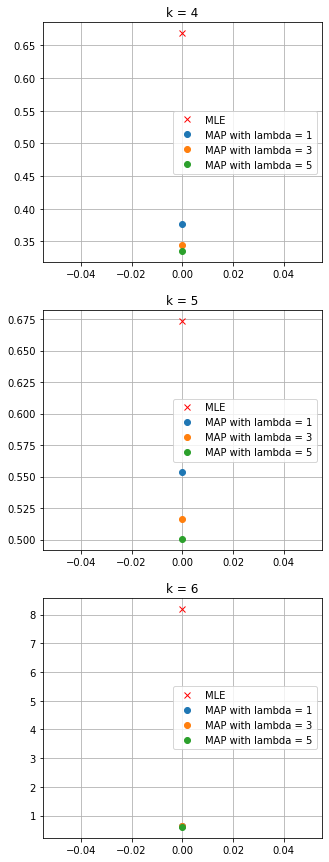

Method: GD


MLE test error:  8.116579369719043
MAP test error:  [8.116172470293774, 8.115358703838844, 8.114544980578042]


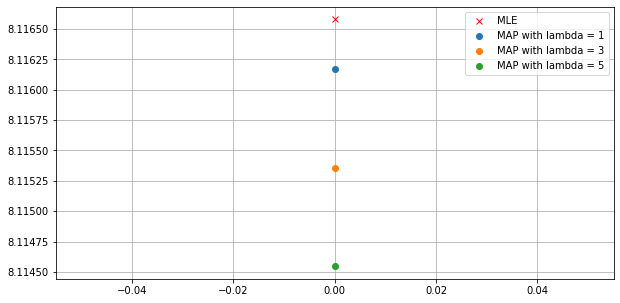

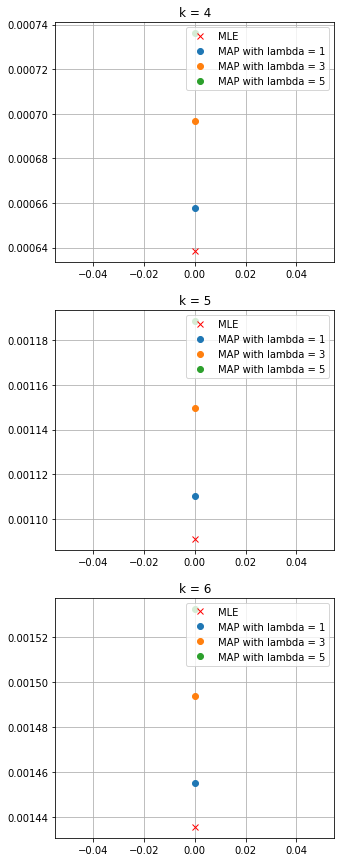

Method: SGD


MLE test error:  7.594253401848637
MAP test error:  [7.455851997725052, 7.1378603634596125, 5.95522185831166]


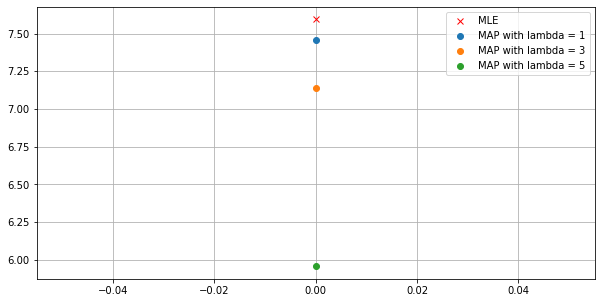

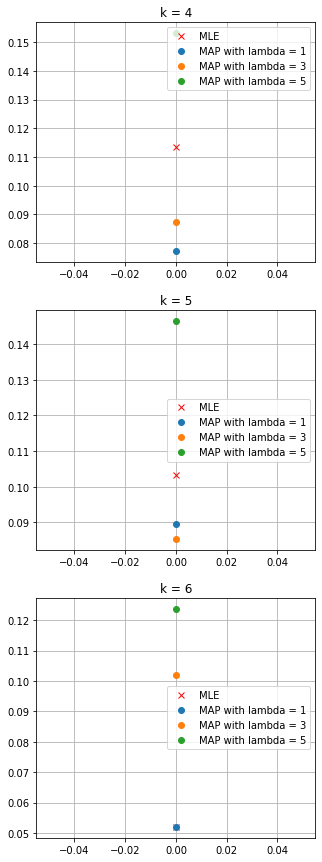

In [124]:
Ns = [100, 250, 500]
for N in Ns:
    print('\n')
    print('-----------------------------------------')
    print('N =', N)
    print('\n')
    
    X = np.linspace(a, b, N)
    e = np.random.normal(0, var, N)
    Y = phi(X, K) @ theta_true + e
    D = (X, Y)
    N_train = int(N / 3 * 2)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, N_train)

    ks_MLE = [2, 3, 6, 10]
    methods = [['NE', 'NE', 'NE', 'NE'], 
               ['GD', 'GD', 'GD', 'GD'], 
               ['SGD', 'SGD', 'SGD', 'SGD']]
    
    for j in range(len(methods)):
        print('#### Method:', methods[j][0], '####')
        thetas_MLE = []
        errs_train_MLE = []
        errs_test_MLE = []
        for i, k in enumerate(ks_MLE):
            thetas_MLE.append(MLE((X_train, Y_train), k, methods[j][i]))
            errs_train_MLE.append(avg_abs_err(thetas_MLE[-1], (X_train, Y_train)))
            errs_test_MLE.append(avg_abs_err(thetas_MLE[-1], (X_test, Y_test)))

        fig, ax = plt.subplots(len(ks_MLE), figsize=(10, 20))

        for i in range(len(ks_MLE)):
            X_plot = np.linspace(a, b, 1000)
            Y_plot = phi(X_plot, ks_MLE[i]) @ thetas_MLE[i]
            ax[i].plot(X_plot, Y_plot, label=f'MLE with {methods[j][i]}', color='k')
            ax[i].scatter(X_train, Y_train, label='Training data', color='b')
            ax[i].scatter(X_test, Y_test, label='Test data', color='r')
            ax[i].set_title('k = ' + str(ks_MLE[i]))
            ax[i].legend()
        plt.show()

        plt.plot(ks_MLE, errs_train_MLE, label="Train set error", color='b')
        plt.plot(ks_MLE, errs_test_MLE, label="Test set error", color='r')
        plt.legend()
        plt.title("Training and test error over k")
        plt.xlabel("K")
        plt.ylabel("Error")
        plt.show()

    ks_MAP = [2, 3, 6, 8]
    thetas_MAP = []
    lams = [1, 3, 5]

    for j in range(len(methods)):
        print('#### Method:', methods[j][0], '####')
        thetas_MAP = []
        for i, k in enumerate(ks_MAP):
            thetas_MAP_l = []
            for lam in lams:
                thetas_MAP_l.append(MAP((X_train, Y_train), k, i, methods[j][i]))
            thetas_MAP.append(thetas_MAP_l)

        for i, k in enumerate(ks_MAP):
            plt.figure(figsize = (20, 5))
            plt.suptitle(f"K = {k}")
            for j, lam in enumerate(lams):
                theta_MAP = thetas_MAP[i][j]
                X_plot = np.linspace(a, b, 1000)
                Y_plot = phi(X_plot, k) @ theta_MAP
                plt.subplot(1, 3, j+1)
                plt.plot(X_plot, Y_plot, label=f"MAP with {methods[j][i]}", color="k")
                plt.scatter(X_train, Y_train, label= "Training Data", color='b')
                plt.scatter(X_test, Y_test, label="Test Data", color='r')
                plt.title(f"lambda = {lam}")
                plt.legend()
        plt.show()
    
    testMLEGD = MLE((X_train, Y_train), K, "GD")
    errMLEGD = np.linalg.norm(testMLEGD - theta_true) / np.linalg.norm(theta_true)
    print(f"Theta MLE GD: {testMLEGD}")
    print(f"Error MLE GD: {errMLEGD}")
    
    testMLESGD = MLE((X_train, Y_train), K, "SGD")
    errMLESGD = np.linalg.norm(testMLESGD - theta_true) / np.linalg.norm(theta_true)
    print(f"Theta MLE SGD: {testMLESGD}")
    print(f"Error MLE SGD: {errMLEGD}")
    
    testMLENE = MLE((X_train, Y_train), K, "NE")
    errMLENE = np.linalg.norm(testMLENE - theta_true) / np.linalg.norm(theta_true)
    print(f"Theta MLE NE: {testMLENE}")
    print(f"Error MLE NE: {errMLENE}")

    print()

    testMAPGD = MAP((X_train, Y_train), K, 1, "GD")
    errMAPGD = np.linalg.norm(testMAPGD - theta_true) / np.linalg.norm(theta_true)
    print(f"Theta MAP GD: {testMAPGD}")
    print(f"Error MAP GD: {errMAPGD}")
    
    testMAPSGD = MAP((X_train, Y_train), K, 1, "SGD")
    errMAPSGD = np.linalg.norm(testMAPSGD - theta_true) / np.linalg.norm(theta_true)
    print(f"Theta MAP SGD: {testMAPSGD}")
    print(f"Error MAP SGD: {errMAPGD}")
    
    testMAPNE = MAP((X_train, Y_train), K, 1, "NE")
    errMAPNE = np.linalg.norm(testMAPNE - theta_true) / np.linalg.norm(theta_true)
    print(f"Theta MAP NE: {testMAPNE}")
    print(f"Error MAP NE: {errMAPNE}")
    print('\n')
    
    K_big = 26
    meths = ['NE', 'GD', 'SGD']
    for m in meths:
        print('Method:', m)
        print('\n')
        theta_MLE_big = MLE((X_train, Y_train), K_big, m)
        thetas_MAP_big = [MAP((X_train, Y_train), K_big, lam, m) for lam in lams]

        MLE_err = avg_abs_err(theta_MLE_big, (X_test, Y_test))
        MAP_err = [avg_abs_err(theta, (X_test, Y_test)) for theta in thetas_MAP_big]
        print("MLE test error: ", MLE_err)
        print("MAP test error: ", MAP_err)

        plt.figure(figsize = (10, 5))
        plt.plot(MLE_err, 'xr', label="MLE")
        for i, lam in enumerate(lams):
            plt.plot(MAP_err[i], 'o', label=f"MAP with lambda = {lam}")
        plt.legend()
        plt.grid()
        plt.show()

        ks = [4, 5, 6]
        lams = [1, 3, 5]

        plt.figure(figsize=(5, 15))
        for i, k in enumerate(ks):
            theta_MLE = MLE((X_train, Y_train), k, m)
            thetas_MAP = [MAP((X_train, Y_train), k, lam, m) for lam in lams]
            MLE_err = err(theta_MLE, k)
            MAP_err = [err(theta_MAP, k) for theta_MAP in thetas_MAP]
            
            plt.subplot(len(ks), 1, i+1)
            plt.plot(MLE_err, 'xr', label="MLE")
            
            for j, lam in enumerate(lams):
                plt.plot(MAP_err[j], 'o', label=f"MAP with lambda = {lam}")
            plt.legend()
            plt.grid()
            plt.title(f'k = {k}')
        plt.show()